In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)

Loading required package: limma


In [3]:
from matplotlib import rcParams
from matplotlib import cm, colors

#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [4]:
plt.rcParams['figure.figsize']=(5,5) #rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300,transparent=True, fontsize=12) #color_map=mymap2)
sc.settings.figdir = '/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/MM_sysVI/DEG_analysis/Microglia_sep/figures'
sc.logging.print_header()

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


# Set up dataframe for pseudobulking

In [5]:
adata = sc.read_h5ad('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/adata_mm_MG_fine_type_WORKING.h5ad')
adata

AnnData object with n_obs × n_vars = 52981 × 19308
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'indiv_treatment_time', 'lesion_status', 'lesion_condition', 'S_score', 'G2M_score', 'Cycling cells', 'S phase', 'Cycling_cells', 'S_phase_cells', 'cluster_annotation', 'cell_leiden_annotated', 'common_innate_immunity_signature', 'IRAS1', 'IRAS2', 'leiden_MG_r0.5', 'leiden_MG_r0.7', 'leiden_MG_r1', 'leiden_MG_r0.3', 'minimal_treatment_map', 'MG_type_fine', 'MG_leiden_annotated', 'NEW_treatment_map', 'individual_lesion_condition', 'MG_type_broad', 'MG_type_fine_reduced', 'MG_type_fine_NEW', 'MG_type_fine_NEW_NUMBERED', 'MG_type_fine_NUMBERED', 'MG_type_fine_LETTER'
   

In [6]:
# Unique values in the 'condition' column
unique_conditions = adata.obs['MG_type_fine_NEW'].unique()
for condition in unique_conditions:
    print(condition)

Microglia_E
cycl_Microglia
Microglia_C
Microglia_D
Microglia_F
Microglia_A
Microglia_B


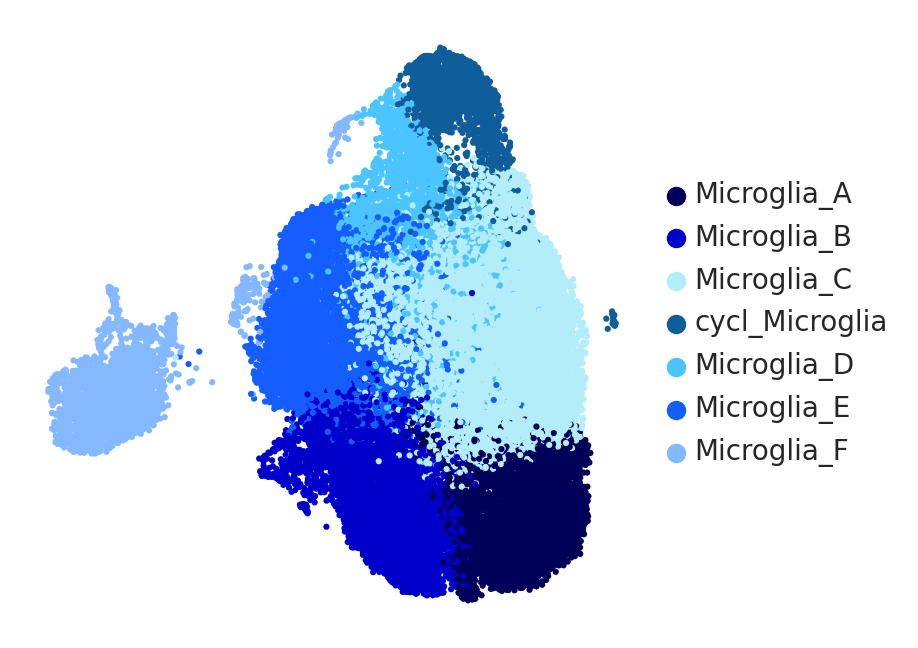

In [7]:
cluster_color = {     
    'cycl_Microglia': '#0f5e9b',  
    'Microglia_A': '#000058',    
    'Microglia_B': '#0000cb',
    'Microglia_C': '#b3edf9',
    'Microglia_D': '#4bc4ff',  
    'Microglia_E': '#145eff', 
    'Microglia_F': '#85b9ff', 
}

#Visualize the clustering and how this is reflected by different technical covariate
sc.pl.umap(adata, color=['MG_type_fine_NEW'], legend_fontsize =float(10) , wspace=0.6, 
           cmap=mymap2,palette=cluster_color, title='',
           legend_fontweight= 'bold', frameon= False, s=20, 
           legend_fontoutline=1)

In [8]:
# Unique values in the 'condition' column
unique_conditions = adata.obs['MG_type_fine_NEW'].unique()
for condition in unique_conditions:
    print(condition)

Microglia_E
cycl_Microglia
Microglia_C
Microglia_D
Microglia_F
Microglia_A
Microglia_B


In [9]:
#cell_type = {str(i): '' for i in range(18)}
cell_type = {
    'cycl_Microglia': 'cycl_Microglia',  
    'Microglia_A': 'Microglia_A',    
    'Microglia_B': 'Microglia_B',
    'Microglia_C': 'Microglia_C',
    'Microglia_D': 'Microglia_D',  
    'Microglia_E': 'Microglia_E', 
    'Microglia_F': 'BAMs', 
}

adata.obs['MG_type_fine_BAM'] = adata.obs['MG_type_fine_NEW'].map(cell_type).astype('category')

In [10]:
# Define the desired order of cell types in the legend
desired_order = ['Microglia_A', 'Microglia_B', 'Microglia_C', 'Microglia_D', 'Microglia_E', 'BAMs', 'cycl_Microglia']

# Reorder the categories in the 'cell_type_fine_mm' column of adata_ol_ol
adata.obs['MG_type_fine_BAM'] = pd.Categorical(adata.obs['MG_type_fine_BAM'], 
                                                    categories=desired_order, 
                                                    ordered=True)

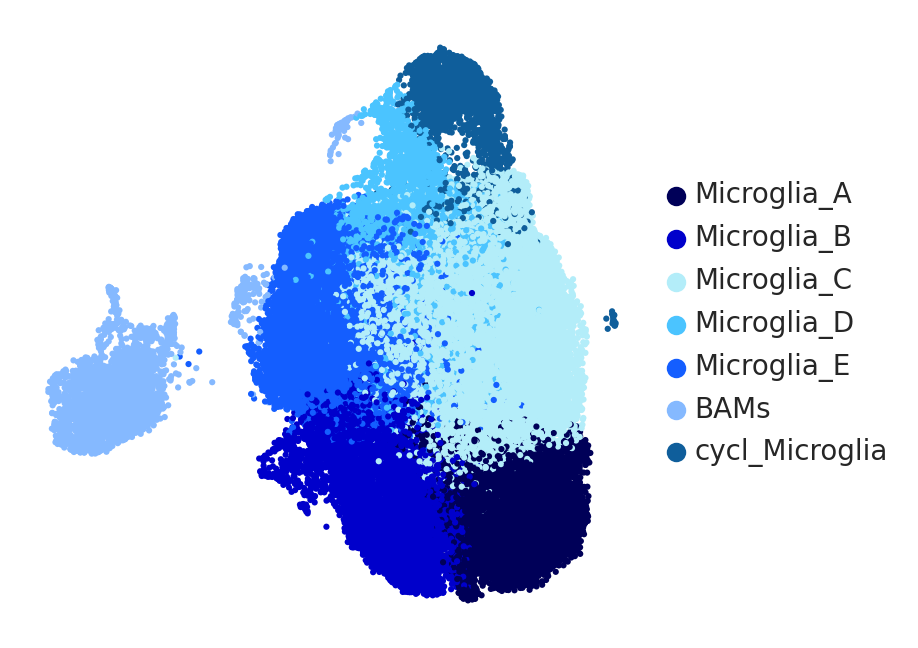

In [11]:
cluster_color = {     
    'cycl_Microglia': '#0f5e9b',  
    'Microglia_A': '#000058',    
    'Microglia_B': '#0000cb',
    'Microglia_C': '#b3edf9',
    'Microglia_D': '#4bc4ff',  
    'Microglia_E': '#145eff', 
    'BAMs': '#85b9ff', 
}

#Visualize the clustering and how this is reflected by different technical covariate
sc.pl.umap(adata, color=['MG_type_fine_BAM'], legend_fontsize =float(10) , wspace=0.6, 
           cmap=mymap2,palette=cluster_color, title='',
           legend_fontweight= 'bold', frameon= False, s=20, 
           legend_fontoutline=1)

In [12]:
#cell_type = {str(i): '' for i in range(18)}
cell_type = {
    'cycl_Microglia': 'cycling',  
    'Microglia_A': 'Mg_A',    
    'Microglia_B': 'Mg_B',
    'Microglia_C': 'Mg_C',
    'Microglia_D': 'Mg_D',  
    'Microglia_E': 'Mg_E', 
    'BAMs': 'BAMs', 
}

adata.obs['cell_type'] = adata.obs['MG_type_fine_BAM'].map(cell_type).astype('category')

In [13]:
# Define the desired order of cell types in the legend
desired_order = ['Mg_A', 'Mg_B', 'Mg_C', 'Mg_D', 'Mg_E', 'BAMs', 'cycling']

# Reorder the categories in the 'cell_type_fine_mm' column of adata_ol_ol
adata.obs['cell_type'] = pd.Categorical(adata.obs['cell_type'], 
                                                    categories=desired_order, 
                                                    ordered=True)

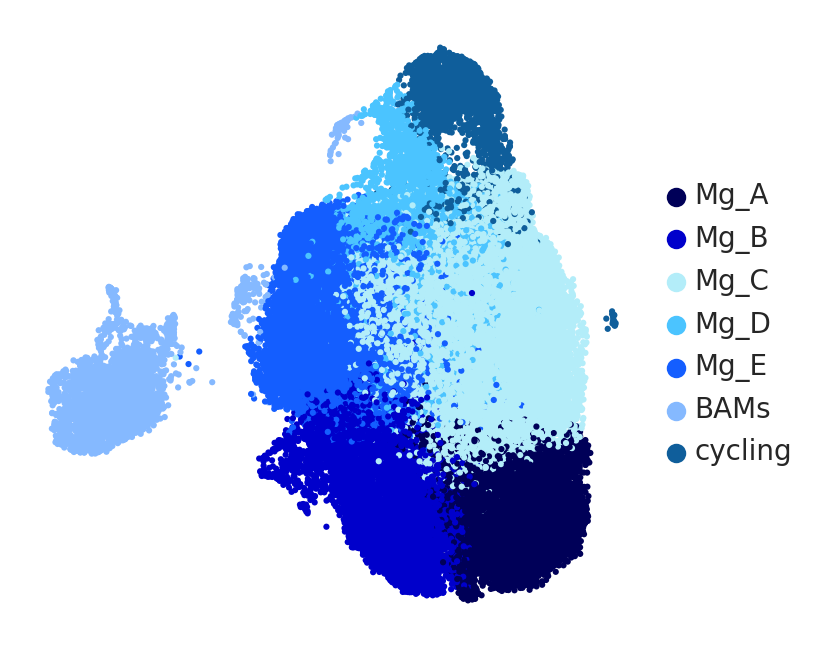

In [82]:
cluster_color = {     
    'cycling': '#0f5e9b',  
    'Mg_A': '#000058',    
    'Mg_B': '#0000cb',
    'Mg_C': '#b3edf9',
    'Mg_D': '#4bc4ff',  
    'Mg_E': '#145eff', 
    'BAMs': '#85b9ff', 
}

#Visualize the clustering and how this is reflected by different technical covariate
sc.pl.umap(adata, color=['cell_type'], legend_fontsize =float(10) , wspace=0.6, 
           cmap=mymap2,palette=cluster_color, title='',
           legend_fontweight= 'bold', frameon= False, s=20, 
           legend_fontoutline=1, save='_MG_reduced.png')

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


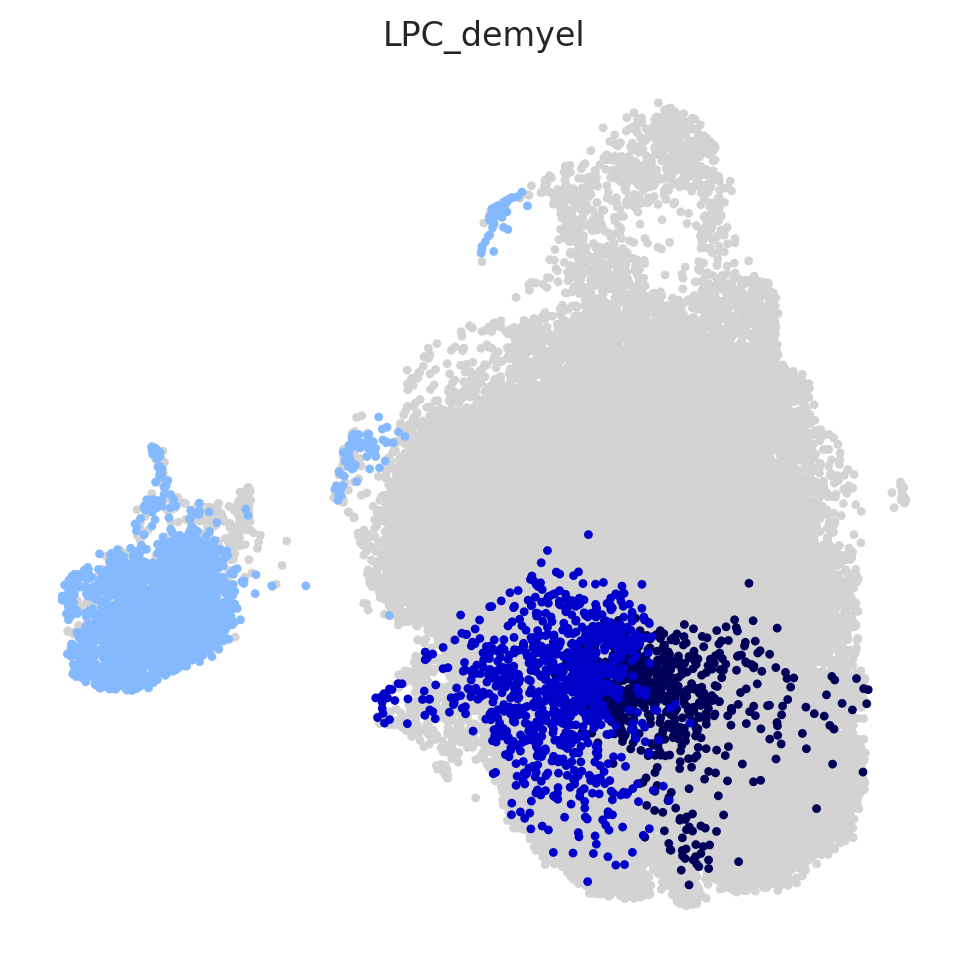

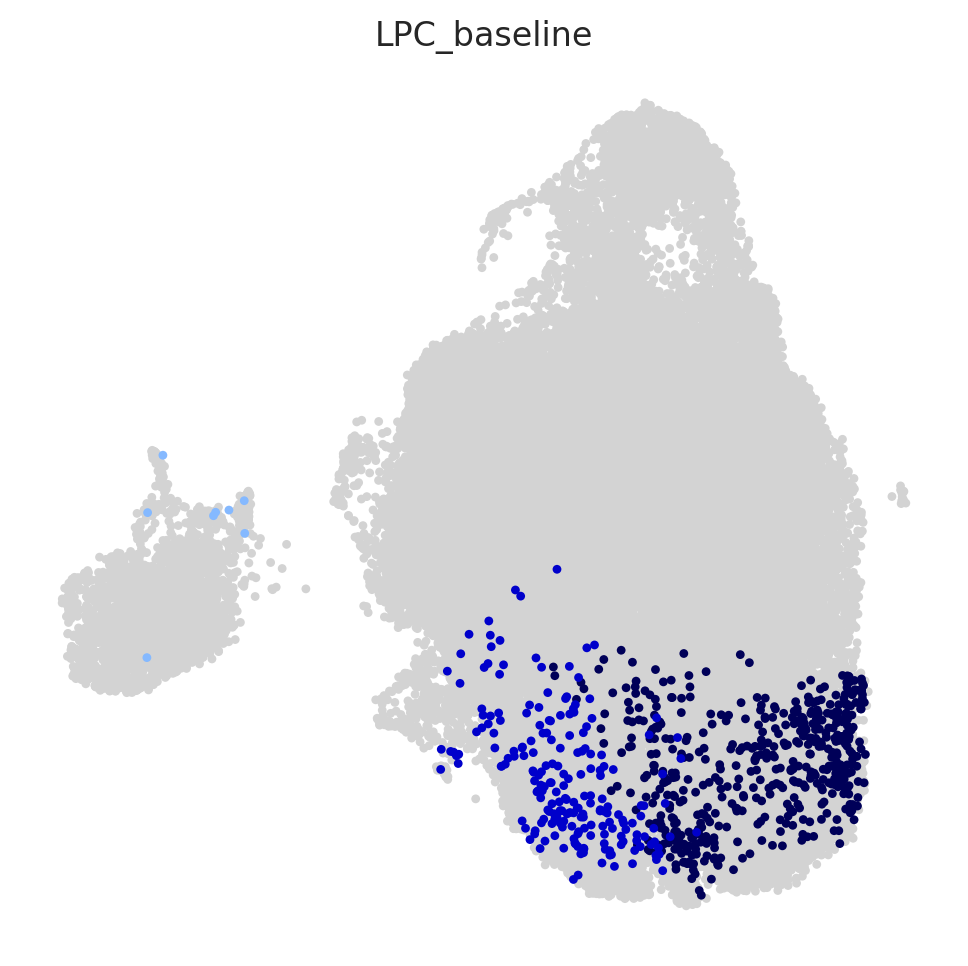

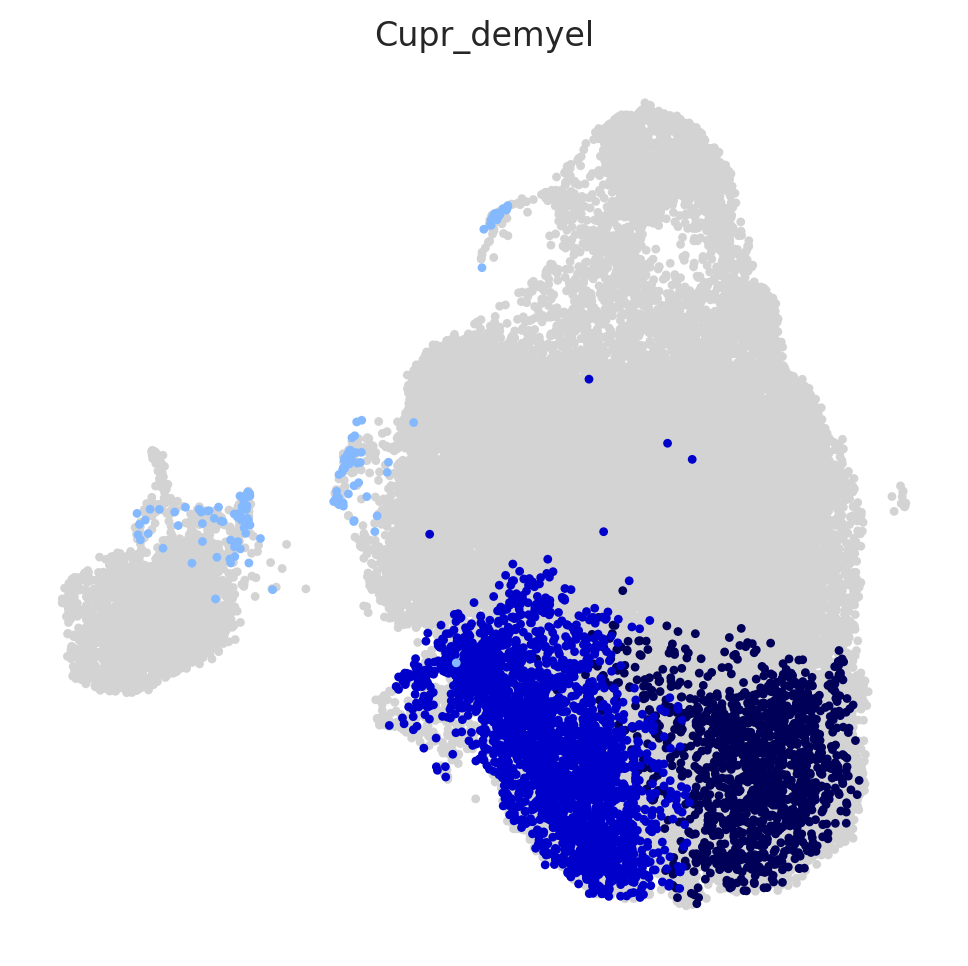

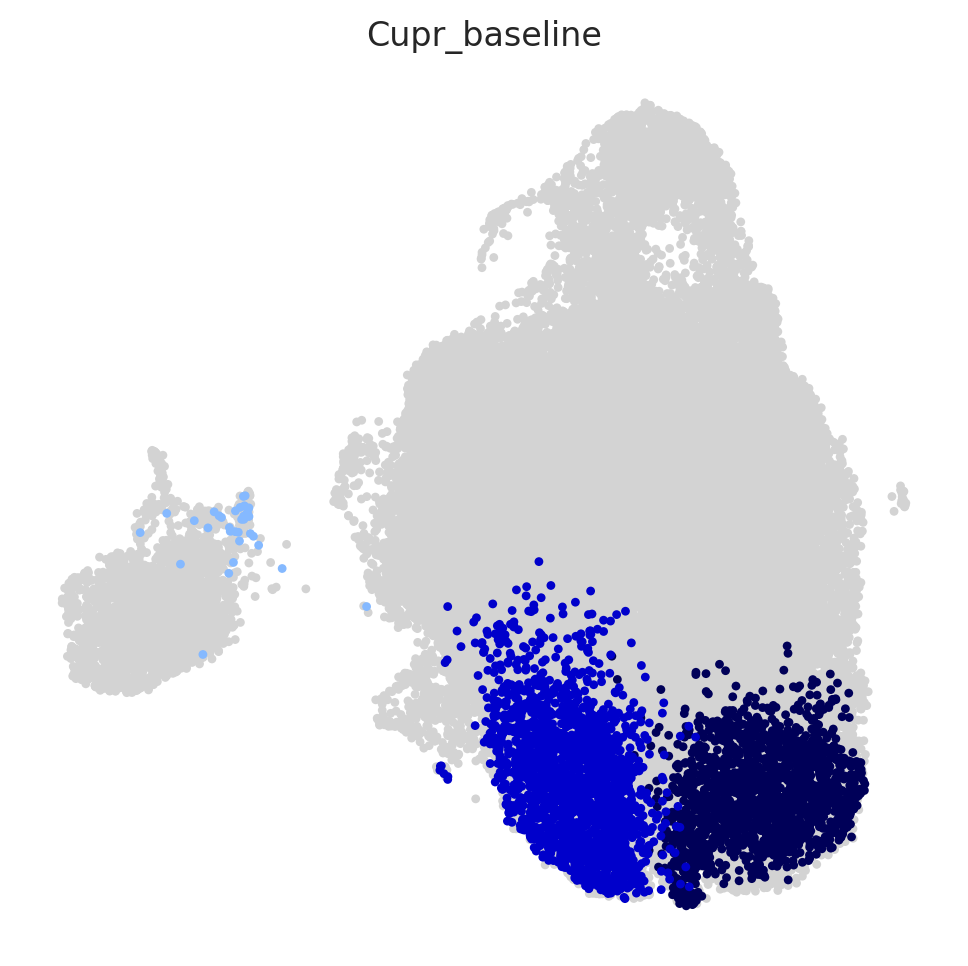

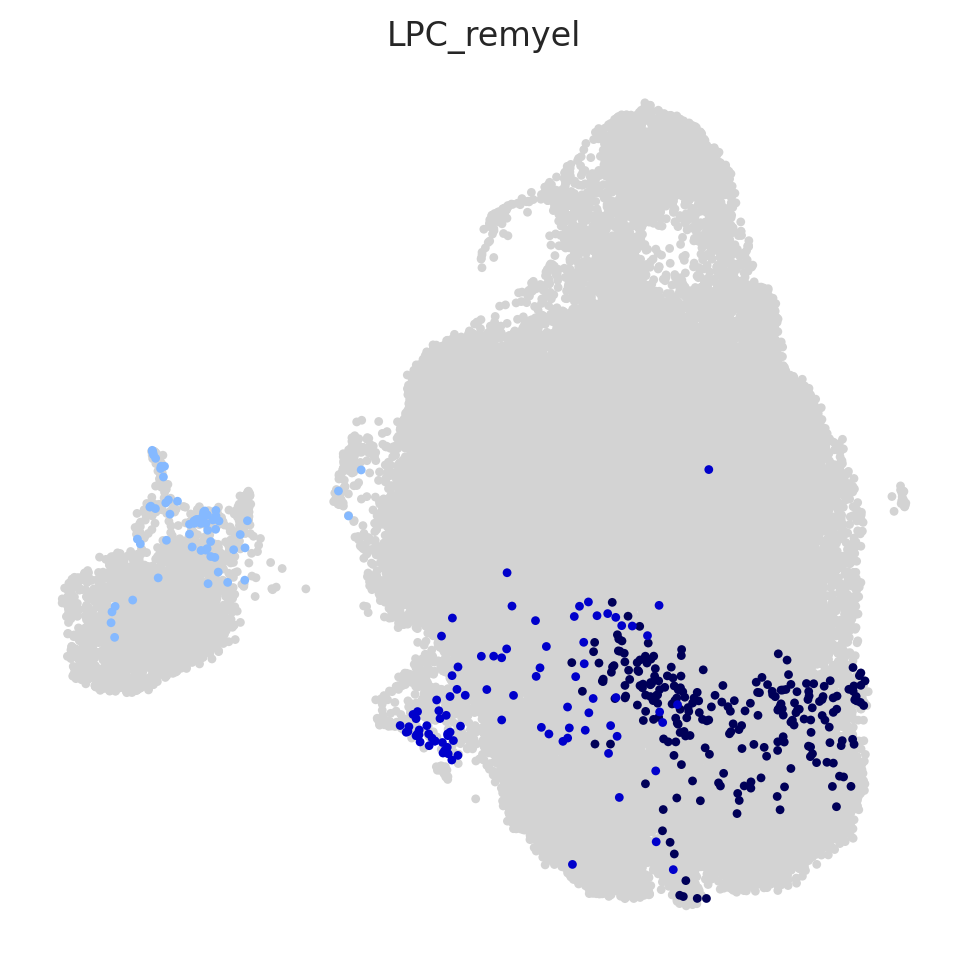

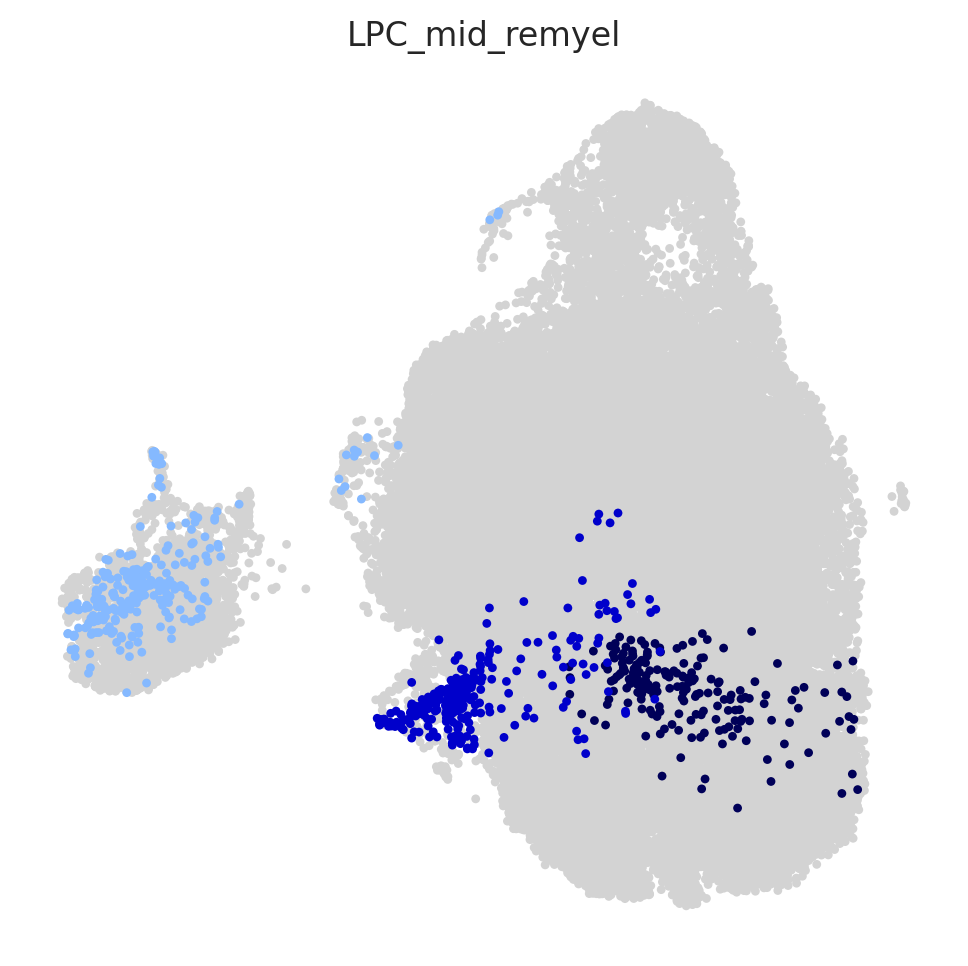

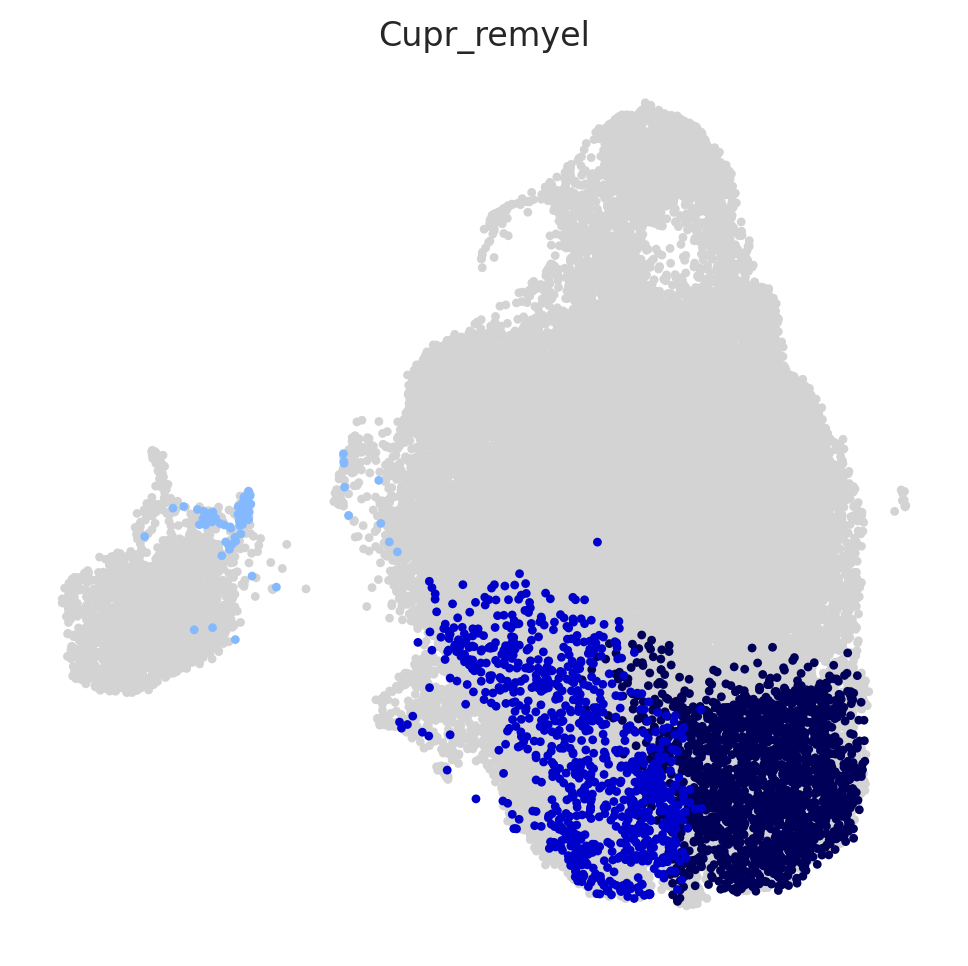

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc

plt.rcParams['figure.figsize']=(5,5) #rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300,transparent=True, fontsize=12) #color_map=mymap2)
sc.settings.figdir = '/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/MM_sysVI/DEG_analysis/Microglia_sep/figures'
sc.logging.print_header()

cluster_color = {     
    'cycling': '#0f5e9b',  
    'Mg_A': '#000058',    
    'Mg_B': '#0000cb',
    'Mg_C': '#b3edf9',
    'Mg_D': '#4bc4ff',  
    'Mg_E': '#145eff', 
    'BAMs': '#85b9ff', 
}

# Set a grey color for cells not in the current lesion_status
grey_color = '#d3d3d3'

# Iterate over unique lesion_statuses
for lesion_status in adata.obs['lesion_status'].unique():
    # Create a mask for cells in the specific lesion_status
    lesion_mask = adata.obs['lesion_status'] == lesion_status

    # Initialize color vector for cells not in the lesion_status
    colors = np.array([grey_color] * adata.shape[0])  # Initialize all to grey

    # Plot UMAP with grey dots first
    plt.figure(figsize=(5, 5))  # Ensure figure size matches settings
    umap_coords = adata.obsm['X_umap']
    grey_mask = ~lesion_mask
    plt.scatter(umap_coords[grey_mask, 0], umap_coords[grey_mask, 1], 
                color=grey_color, s=10, edgecolor='none')

    # Overlay cell type colors on top
    for cell_type in cluster_color:
        # Assign the specific cluster color for cells of the current type in the lesion_status
        cell_type_mask = (adata.obs['cell_type'] == cell_type) & lesion_mask
        plt.scatter(umap_coords[cell_type_mask, 0], umap_coords[cell_type_mask, 1], 
                    color=cluster_color[cell_type], s=10, edgecolor='none')

    # Customize plot appearance
    plt.title(f"{lesion_status}", fontsize=12)  # Ensure title is added with fontsize
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    # Remove grid and axes
    plt.grid(False)
    plt.gca().set_axis_off()

    # Save the plot with specified parameters
    plt.tight_layout()
    plt.savefig(f"{sc.settings.figdir}/{lesion_status}_combined_umap.png", dpi=300, transparent=True)

    # Show the plot in the console
    plt.show()

    # Close the plot
    plt.close()

In [14]:
#cell_type = {str(i): '' for i in range(18)}
cell_type = {
    'cycl_Microglia': 'cycl',  
    'Microglia_A': 'A',    
    'Microglia_B': 'B',
    'Microglia_C': 'C',
    'Microglia_D': 'D',  
    'Microglia_E': 'E', 
    'BAMs': 'BAMs', 
}

adata.obs['cell_type_abbrev'] = adata.obs['MG_type_fine_BAM'].map(cell_type).astype('category')

In [15]:
# Define the desired order of cell types in the legend
desired_order = ['A', 'B', 'C', 'D', 'E', 'BAMs', 'cycl']

# Reorder the categories in the 'cell_type_fine_mm' column of adata_ol_ol
adata.obs['cell_type_abbrev'] = pd.Categorical(adata.obs['cell_type_abbrev'], 
                                                    categories=desired_order, 
                                                    ordered=True)

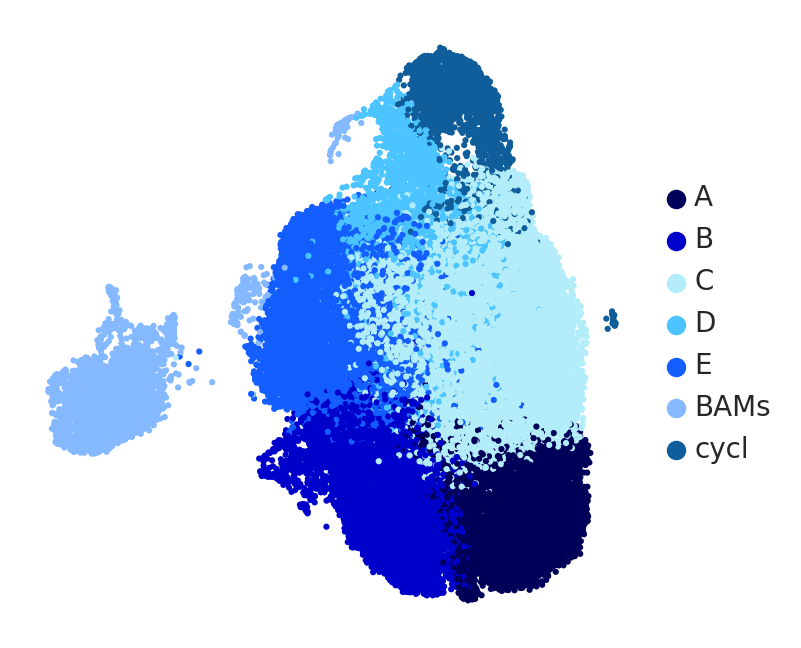

In [108]:
cluster_color = {     
    'cycl': '#0f5e9b',  
    'A': '#000058',    
    'B': '#0000cb',
    'C': '#b3edf9',
    'D': '#4bc4ff',  
    'E': '#145eff', 
    'BAMs': '#85b9ff', 
}

#Visualize the clustering and how this is reflected by different technical covariate
sc.pl.umap(adata, color=['cell_type_abbrev'], legend_fontsize =float(10) , wspace=0.6, 
           cmap=mymap2,palette=cluster_color, title='',
           legend_fontweight= 'bold', frameon= False, s=20, 
           legend_fontoutline=1, save='_MG_abbrev.png')

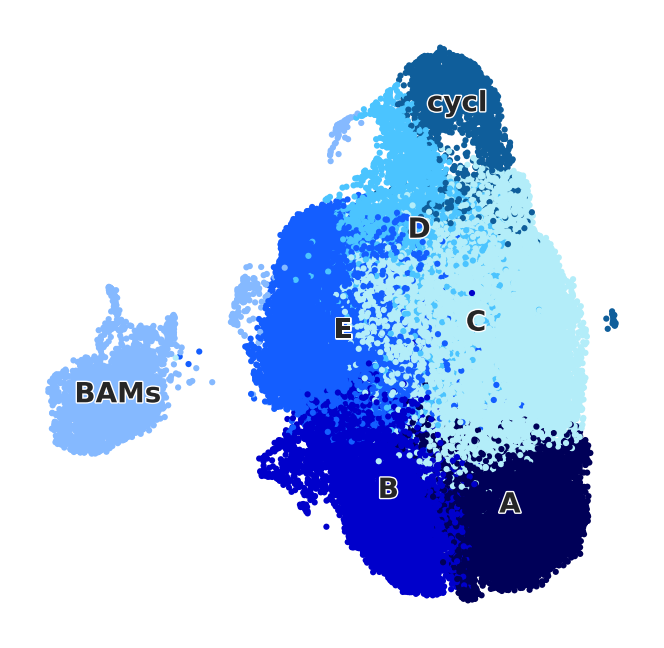

In [109]:
cluster_color = {     
    'cycl': '#0f5e9b',  
    'A': '#000058',    
    'B': '#0000cb',
    'C': '#b3edf9',
    'D': '#4bc4ff',  
    'E': '#145eff', 
    'BAMs': '#85b9ff', 
}

#Visualize the clustering and how this is reflected by different technical covariate
sc.pl.umap(adata, color=['cell_type_abbrev'], legend_fontsize =float(10) , wspace=0.6, 
           cmap=mymap2,palette=cluster_color, title='', legend_loc='on data',
           legend_fontweight= 'bold', frameon= False, s=20, 
           legend_fontoutline=1, save='_MG_abbrev2.png')

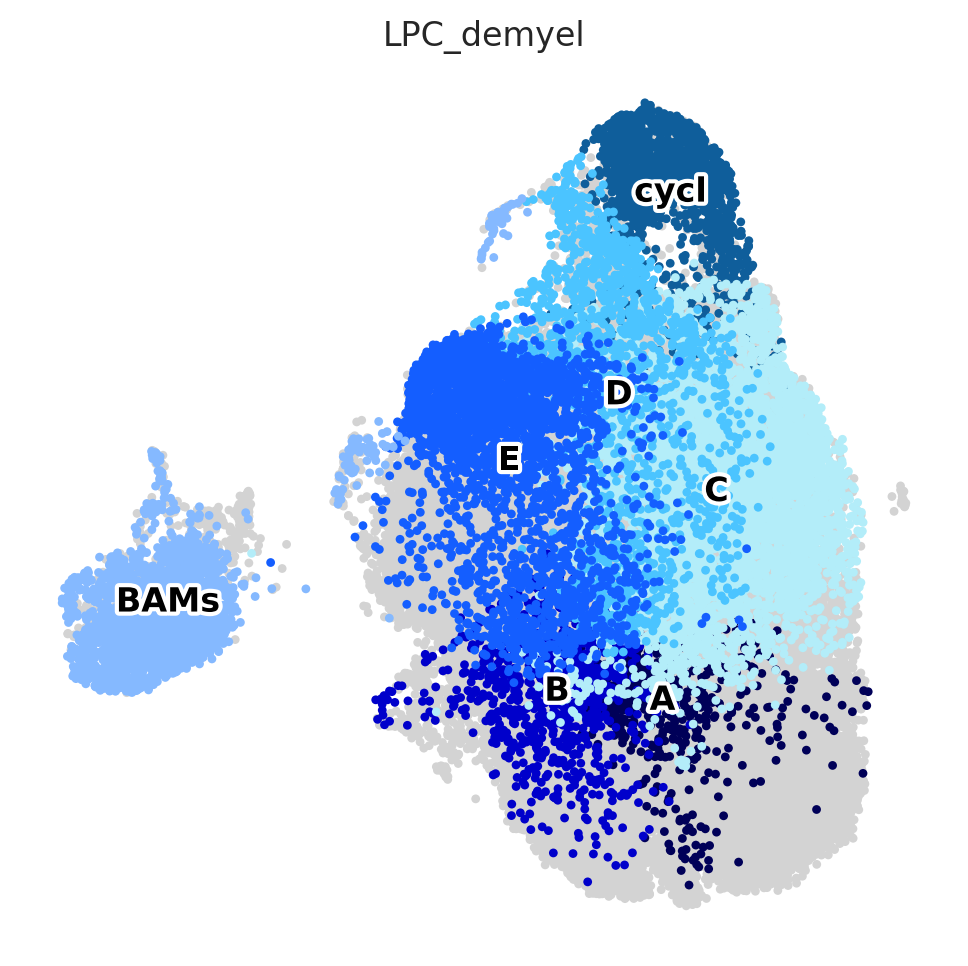

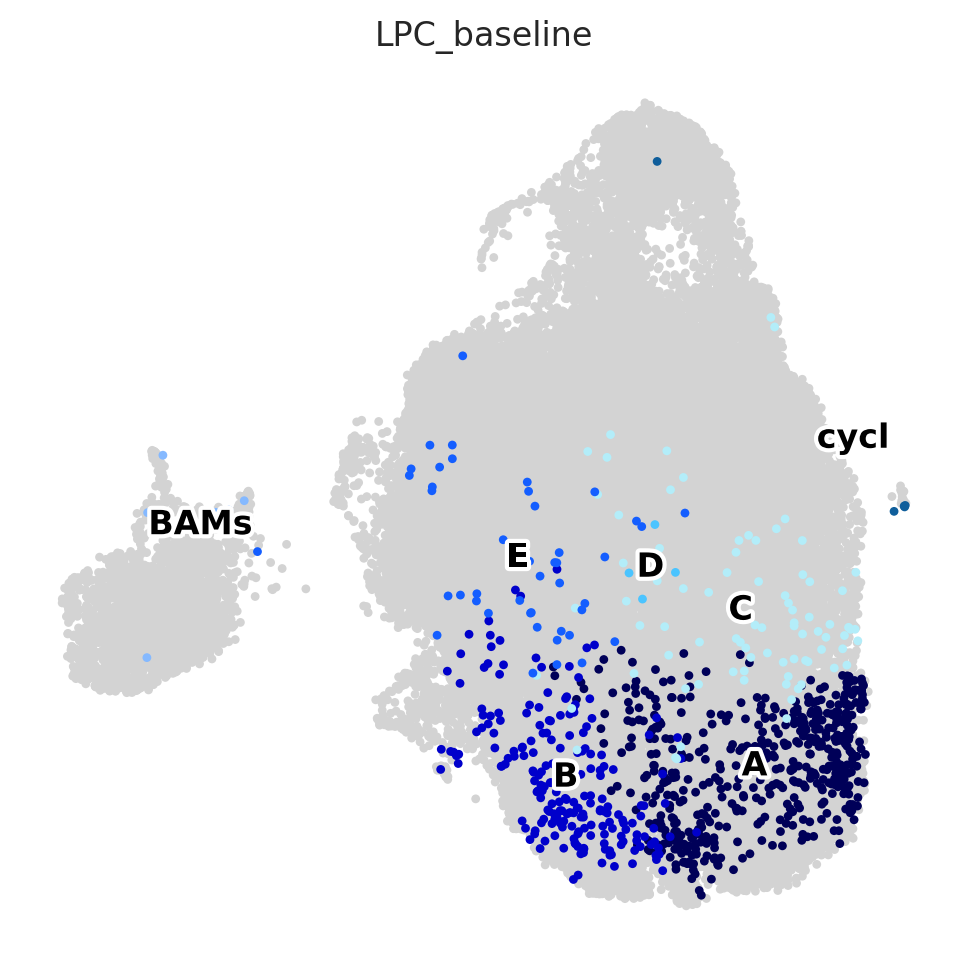

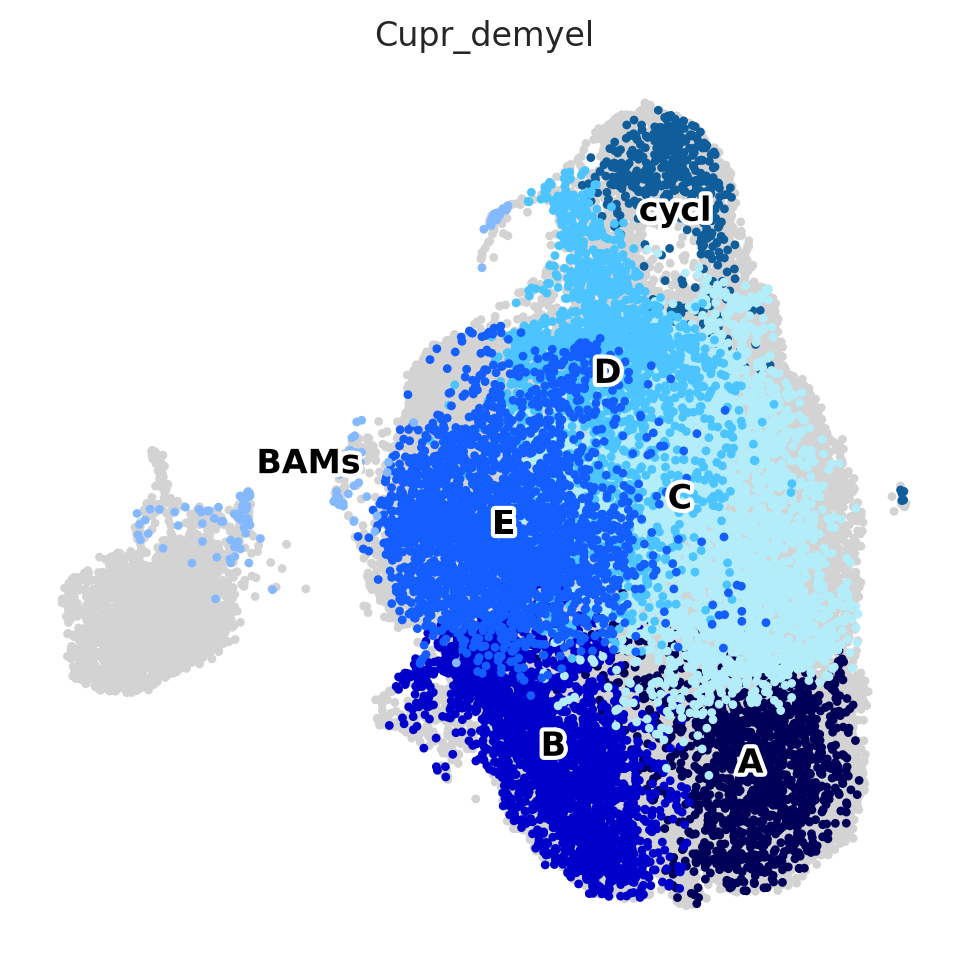

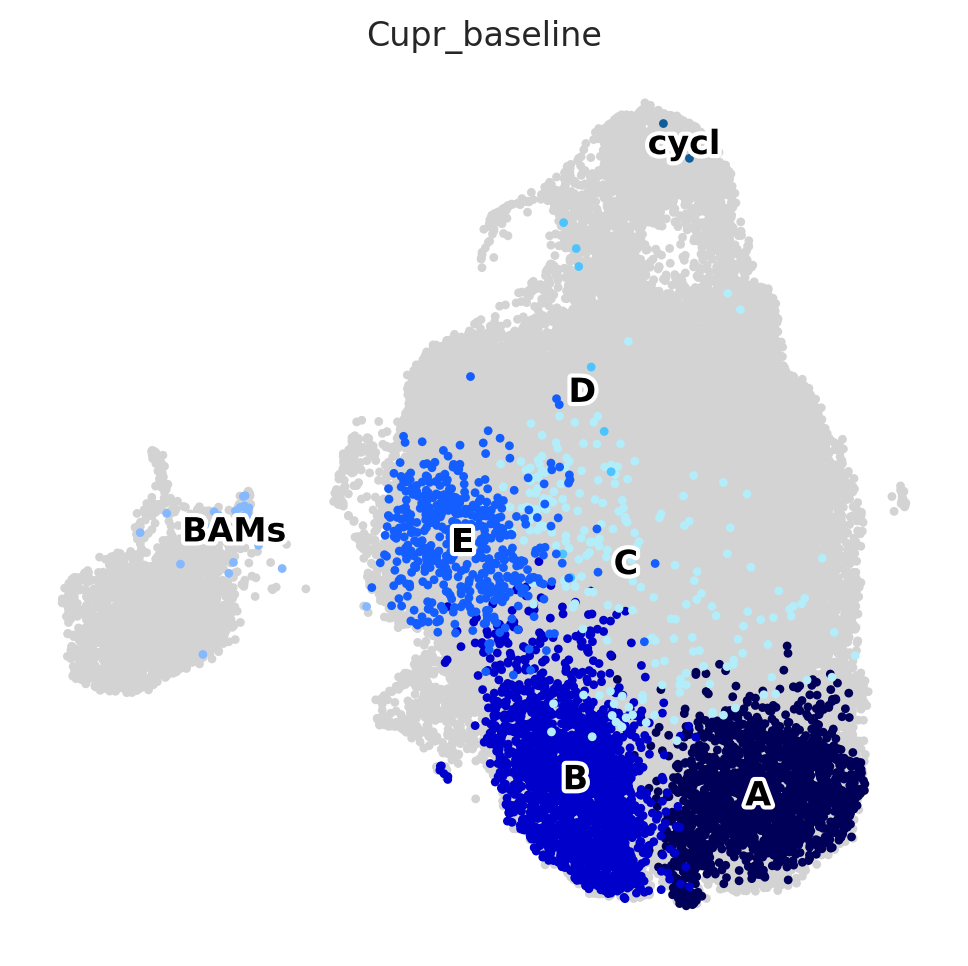

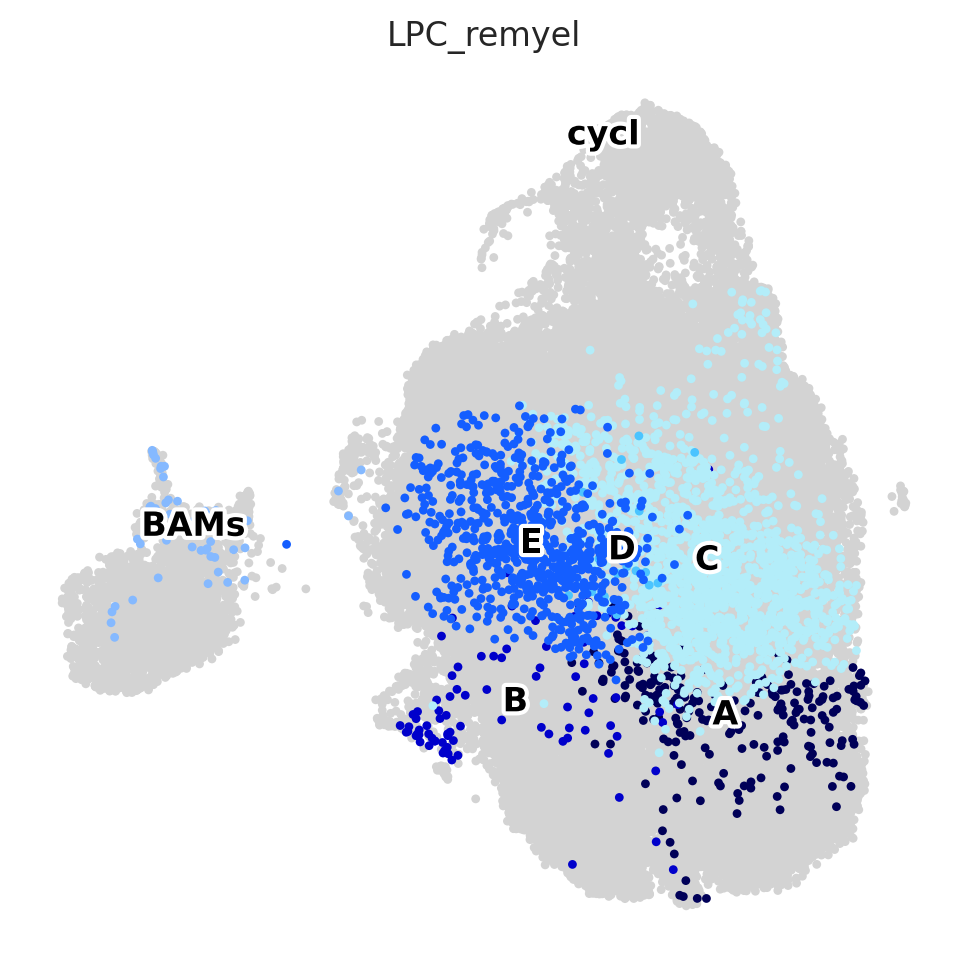

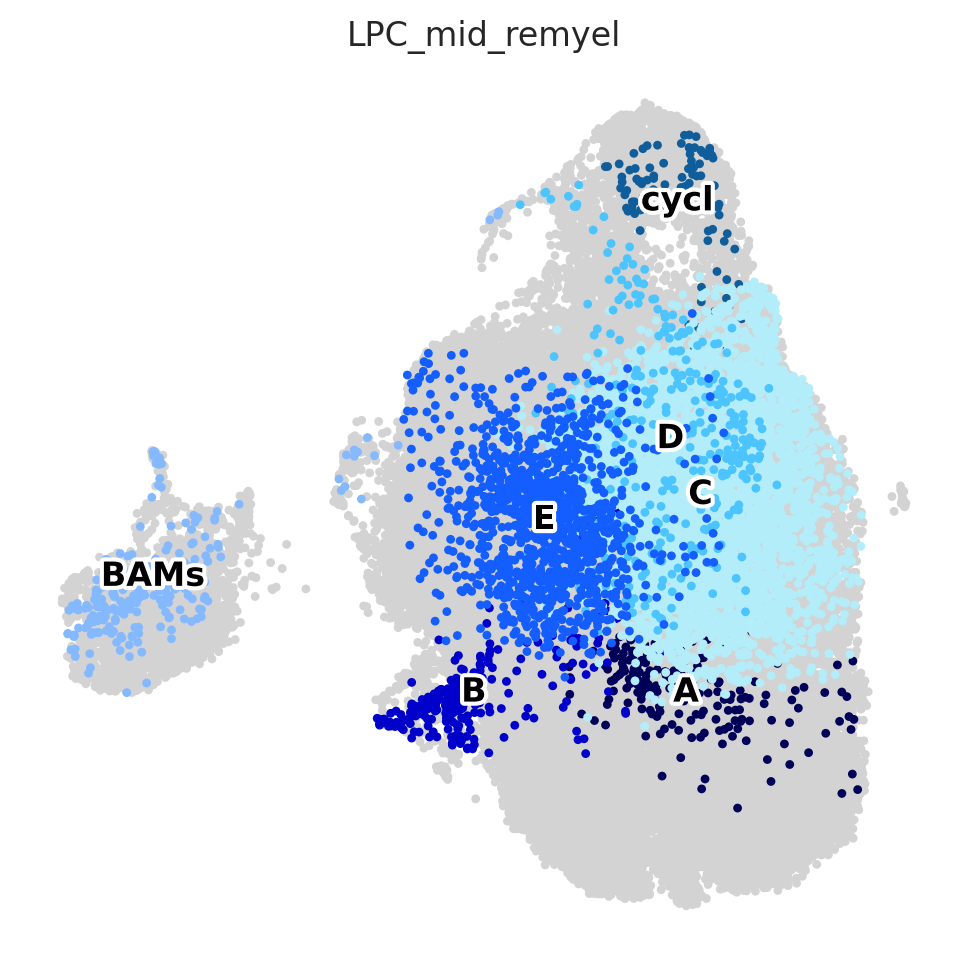

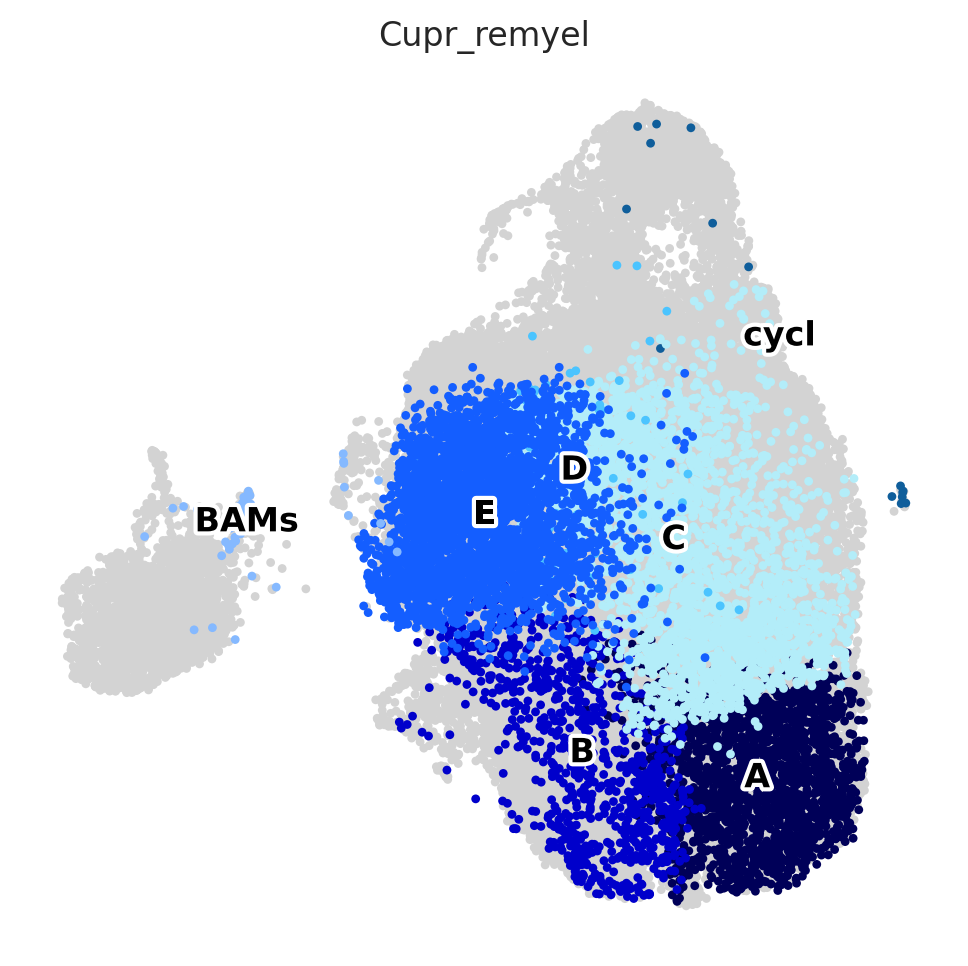

In [110]:
cluster_color = {     
    'cycl': '#0f5e9b',  
    'A': '#000058',    
    'B': '#0000cb',
    'C': '#b3edf9',
    'D': '#4bc4ff',  
    'E': '#145eff', 
    'BAMs': '#85b9ff', 
}
# Set a grey color for cells not in the current lesion_status
grey_color = '#d3d3d3'

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from matplotlib import patheffects  # Import for text outline effects

# Iterate over unique lesion_statuses
for lesion_status in adata.obs['lesion_status'].unique():
    # Create a mask for cells in the specific lesion_status
    lesion_mask = adata.obs['lesion_status'] == lesion_status

    # Initialize color vector for cells not in the lesion_status
    colors = np.array([grey_color] * adata.shape[0])  # Initialize all to grey

    # Plot UMAP with grey dots first
    plt.figure(figsize=(5, 5))  # Ensure figure size matches settings
    umap_coords = adata.obsm['X_umap']
    grey_mask = ~lesion_mask
    plt.scatter(umap_coords[grey_mask, 0], umap_coords[grey_mask, 1], 
                color=grey_color, s=10, edgecolor='none')

    # Overlay cell type colors on top
    for cell_type, cell_color in cluster_color.items():
        # Assign the specific cluster color for cells of the current type in the lesion_status
        cell_type_mask = (adata.obs['cell_type_abbrev'] == cell_type) & lesion_mask
        plt.scatter(umap_coords[cell_type_mask, 0], umap_coords[cell_type_mask, 1], 
                    color=cell_color, s=10, edgecolor='none')

        # Add labels to the UMAP at the centroid of the cluster
        if cell_type_mask.sum() > 0:  # Ensure there are points in the cluster
            centroid = umap_coords[cell_type_mask].mean(axis=0)  # Calculate centroid
            text = plt.text(
                centroid[0], centroid[1], cell_type, fontsize=12, color='black',
                ha='center', va='center', fontweight='bold'
            )

            # Add white outline to the text
            text.set_path_effects([
                patheffects.Stroke(linewidth=3, foreground='white'),  # White outline
                patheffects.Normal()  # Normal text on top
            ])

    # Customize plot appearance
    plt.title(f"{lesion_status}", fontsize=12)  # Ensure title is added with fontsize
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    # Remove grid and axes
    plt.grid(False)
    plt.gca().set_axis_off()

    # Save the plot with specified parameters
    plt.tight_layout()
    plt.savefig(f"{sc.settings.figdir}/{lesion_status}_combined_umap_with_labels_mg.png", dpi=300, transparent=True)

    # Show the plot in the console
    plt.show()

    # Close the plot
    plt.close()

In [16]:
adata_sub = adata[adata.obs['lesion_status'] != 'LPC_mid_remyel']
adata_sub

View of AnnData object with n_obs × n_vars = 46374 × 19308
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'indiv_treatment_time', 'lesion_status', 'lesion_condition', 'S_score', 'G2M_score', 'Cycling cells', 'S phase', 'Cycling_cells', 'S_phase_cells', 'cluster_annotation', 'cell_leiden_annotated', 'common_innate_immunity_signature', 'IRAS1', 'IRAS2', 'leiden_MG_r0.5', 'leiden_MG_r0.7', 'leiden_MG_r1', 'leiden_MG_r0.3', 'minimal_treatment_map', 'MG_type_fine', 'MG_leiden_annotated', 'NEW_treatment_map', 'individual_lesion_condition', 'MG_type_broad', 'MG_type_fine_reduced', 'MG_type_fine_NEW', 'MG_type_fine_NEW_NUMBERED', 'MG_type_fine_NUMBERED', 'MG_type_fine_LET

In [90]:
# Unique values in the 'condition' column
unique_conditions = adata.obs['cell_type'].unique()
for condition in unique_conditions:
    print(condition)

Mg_E
cycling
Mg_C
Mg_D
BAMs
Mg_A
Mg_B


In [91]:
# Unique values in the 'condition' column
unique_conditions = adata.obs['MG_type_fine_BAM'].unique()
for condition in unique_conditions:
    print(condition)

Microglia_E
cycl_Microglia
Microglia_C
Microglia_D
BAMs
Microglia_A
Microglia_B


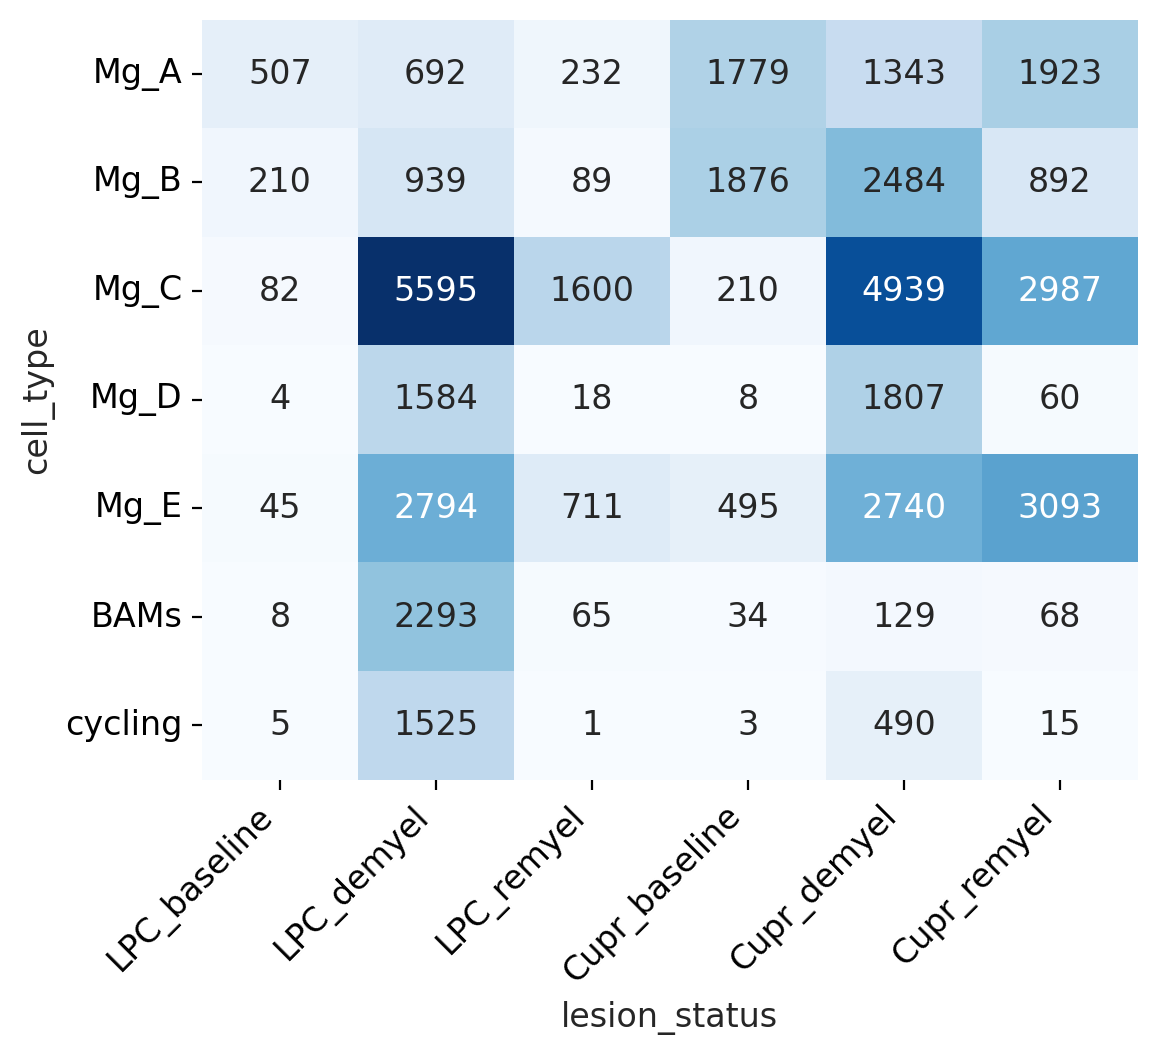

In [111]:
import seaborn as sb

plt.figure(figsize=(6, 5))
crosstab_df = pd.crosstab(adata_sub.obs.cell_type, adata_sub.obs.lesion_status)

ax = sb.heatmap(crosstab_df, cmap='Blues', annot=True, fmt="d", cbar=False, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.grid(False)

# Save the heatmap as a PNG file
output_path = "./figures/PB_heatmap.png"  # Change the path and filename if needed
plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

# Show the heatmap
plt.show()

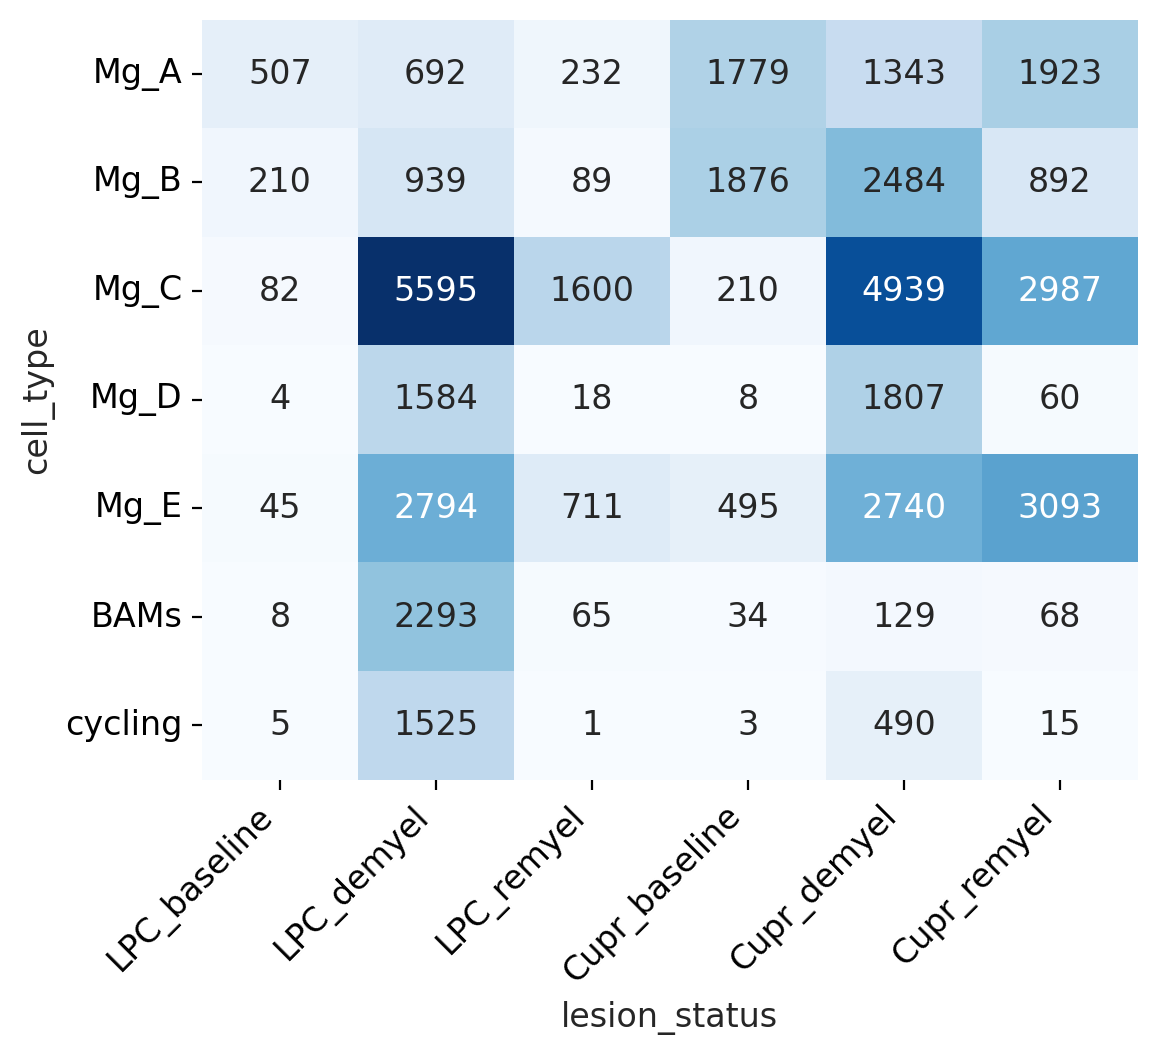

In [112]:
# Define the desired order for the x-axis (lesion_status)
desired_order = ['LPC_baseline', 'LPC_demyel', 'LPC_remyel', 'Cupr_baseline', 'Cupr_demyel', 'Cupr_remyel']

# Reorder the lesion_status column in adata_sub.obs
adata_sub.obs['lesion_status'] = pd.Categorical(
    adata_sub.obs['lesion_status'], categories=desired_order, ordered=True
)

# Create the crosstab again
crosstab_df = pd.crosstab(adata_sub.obs.cell_type, adata_sub.obs.lesion_status)

# Plot the heatmap
plt.figure(figsize=(6, 5))
ax = sb.heatmap(crosstab_df, cmap='Blues', annot=True, fmt="d", cbar=False, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.grid(False)

# Save the heatmap as a PNG file
output_path = "./figures/PB_heatmap_ordered.png"  # Change the path and filename if needed
plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

# Show the heatmap
plt.show()

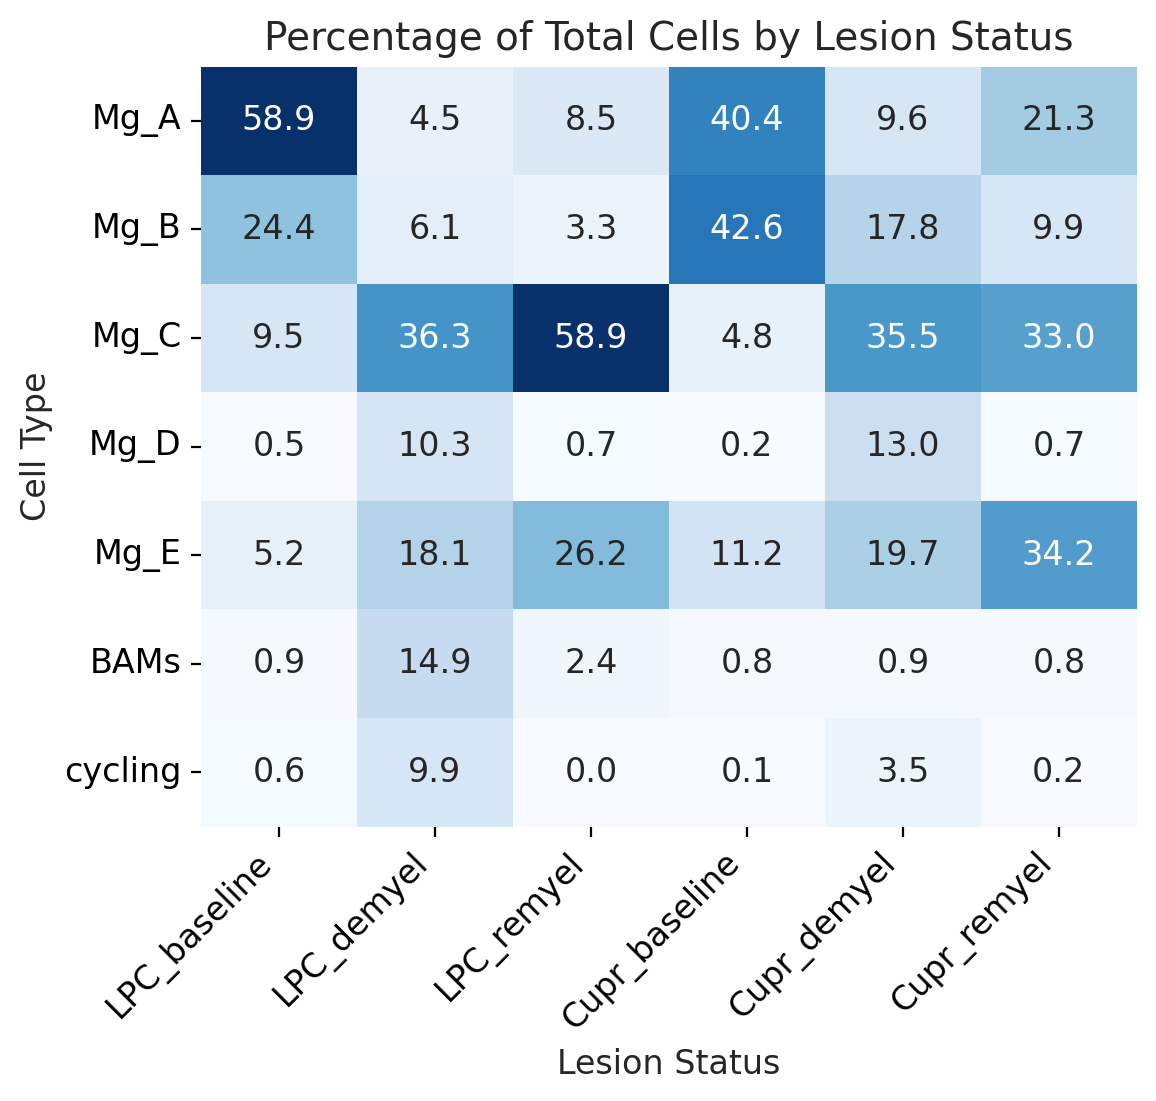

In [113]:
# Create the crosstab with counts
crosstab_df = pd.crosstab(adata_sub.obs.cell_type, adata_sub.obs.lesion_status)

# Normalize each column to percentages
percentage_df = crosstab_df.div(crosstab_df.sum(axis=0), axis=1) * 100

# Plot the heatmap
plt.figure(figsize=(6, 5))
ax = sb.heatmap(percentage_df, cmap='Blues', annot=True, fmt=".1f", cbar=False, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.grid(False)

# Add labels and title (optional)
ax.set_xlabel("Lesion Status", fontsize=12)
ax.set_ylabel("Cell Type", fontsize=12)
ax.set_title("Percentage of Total Cells by Lesion Status", fontsize=14)

# Save the heatmap as a PNG file
output_path = "./figures/PB_heatmap_percentage_ordered.png"  # Change the path and filename if needed
plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

# Show the heatmap
plt.show()

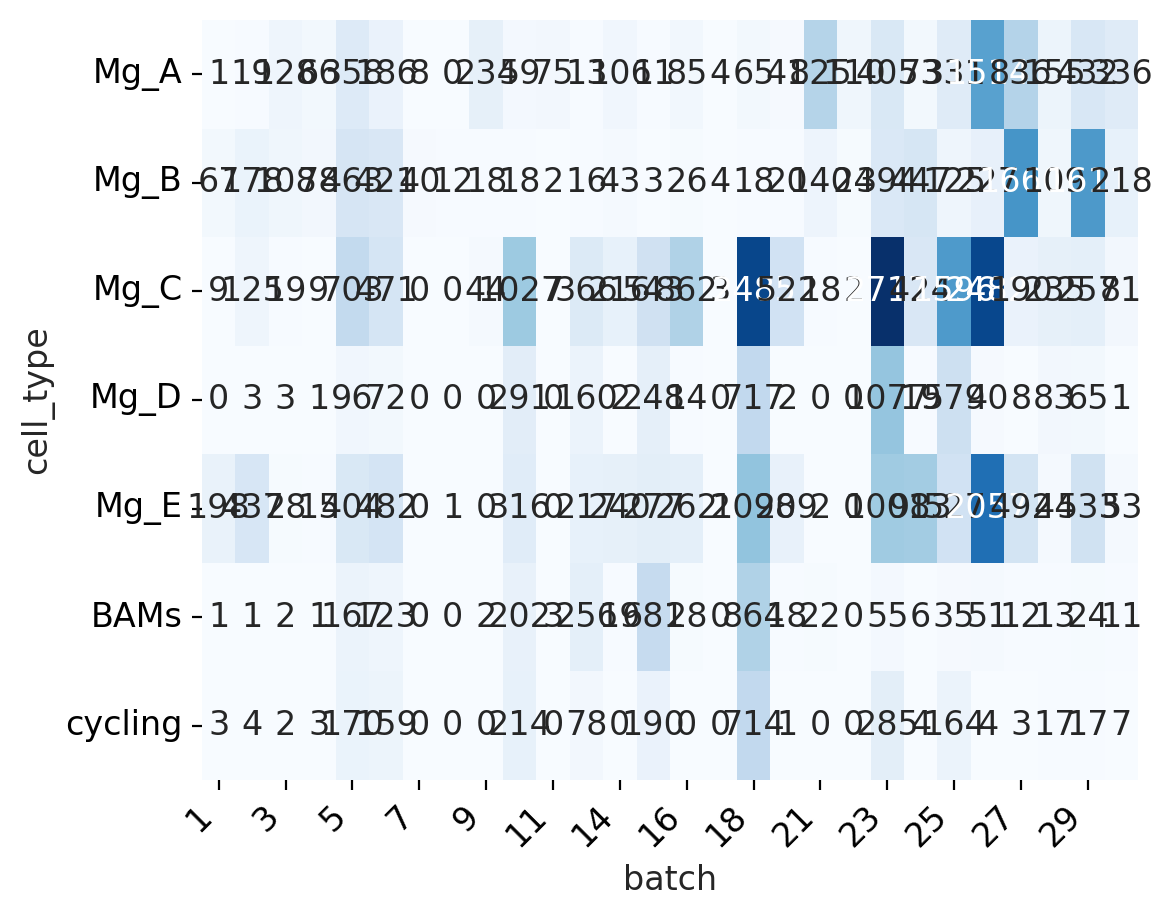

In [101]:
# Create the crosstab again
crosstab_df = pd.crosstab(adata_sub.obs.cell_type, adata_sub.obs.batch)

# Plot the heatmap
plt.figure(figsize=(6, 5))
ax = sb.heatmap(crosstab_df, cmap='Blues', annot=True, fmt="d", cbar=False, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.grid(False)

# Show the heatmap
plt.show()

# Subset to cell type/condition if needed: ie OPC, demyelination

In [17]:
#cell_type = {str(i): '' for i in range(18)}
cell_type = {
    'cycl_Microglia': 'cycl',  
    'Microglia_A': 'Mg_A',    
    'Microglia_B': 'Mg_B',
    'Microglia_C': 'DAMs',
    'Microglia_D': 'DAMs',  
    'Microglia_E': 'DAMs', 
    'BAMs': 'BAMs', 
}

adata.obs['cell_type'] = adata.obs['MG_type_fine_BAM'].map(cell_type).astype('category')

In [18]:
# Define the desired order of cell types in the legend
desired_order = ['Mg_A', 'Mg_B', 'DAMs', 'BAMs', 'cycl']

# Reorder the categories in the 'cell_type_fine_mm' column of adata_ol_ol
adata.obs['cell_type'] = pd.Categorical(adata.obs['cell_type'], 
                                                    categories=desired_order, 
                                                    ordered=True)

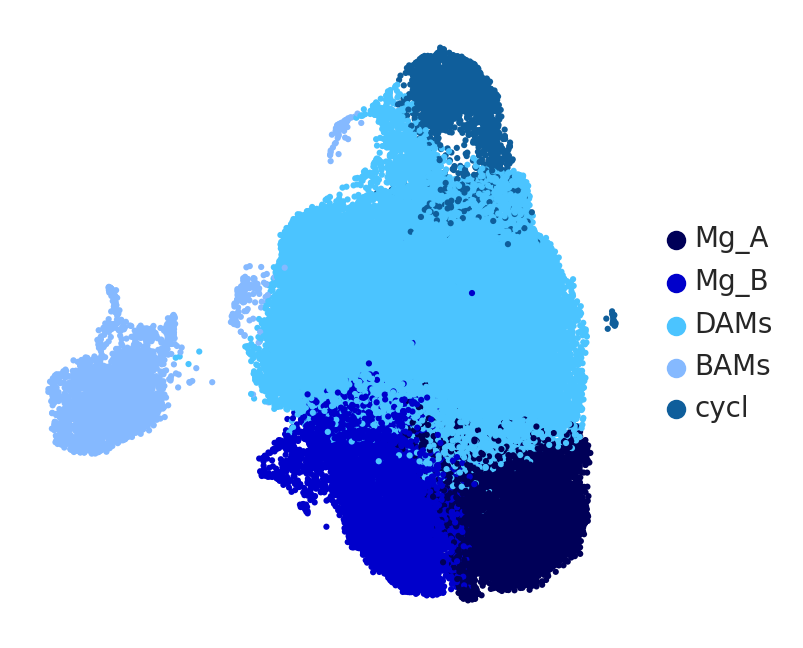

In [19]:
cluster_color = {     
    'cycl': '#0f5e9b',  
    'Mg_A': '#000058',    
    'Mg_B': '#0000cb', 
    'DAMs': '#4bc4ff', 
    'BAMs': '#85b9ff', 
}

#Visualize the clustering and how this is reflected by different technical covariate
sc.pl.umap(adata, color=['cell_type'], legend_fontsize =float(10) , wspace=0.6, 
           cmap=mymap2,palette=cluster_color, title='',
           legend_fontweight= 'bold', frameon= False, s=20, 
           legend_fontoutline=1, save='_MG_reduced_SEP_DAMs.png')

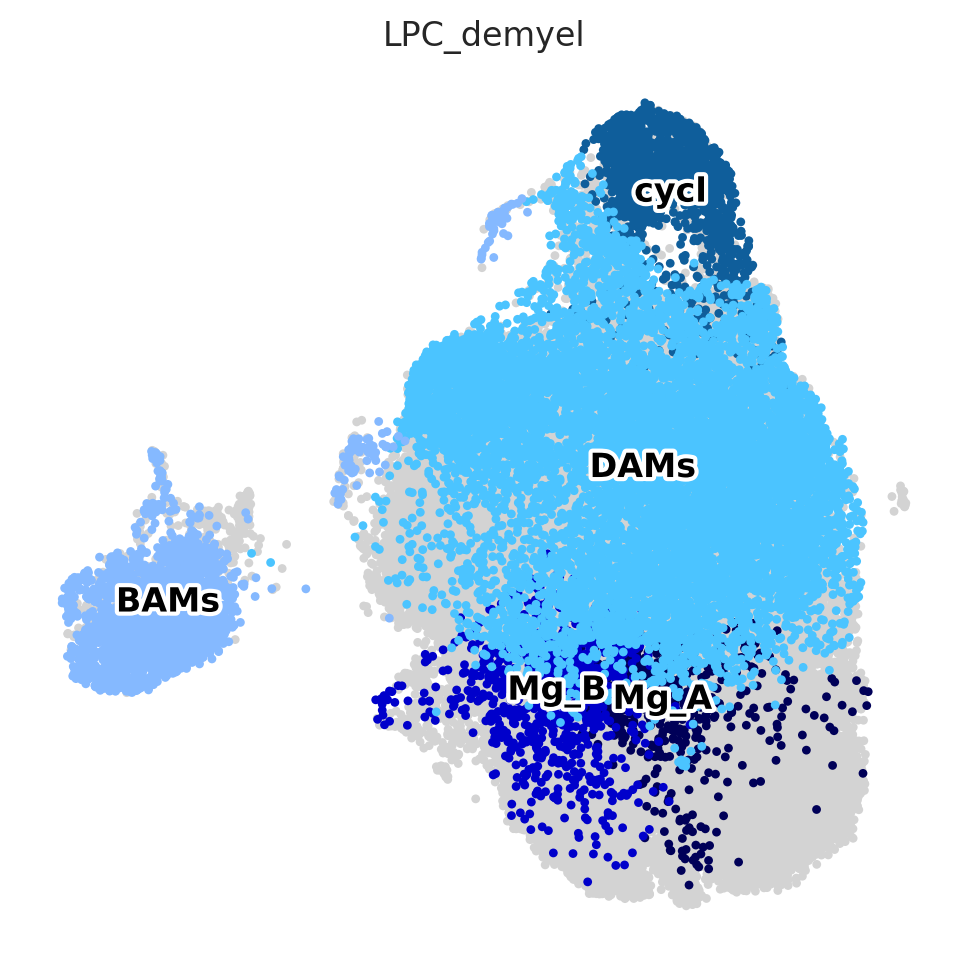

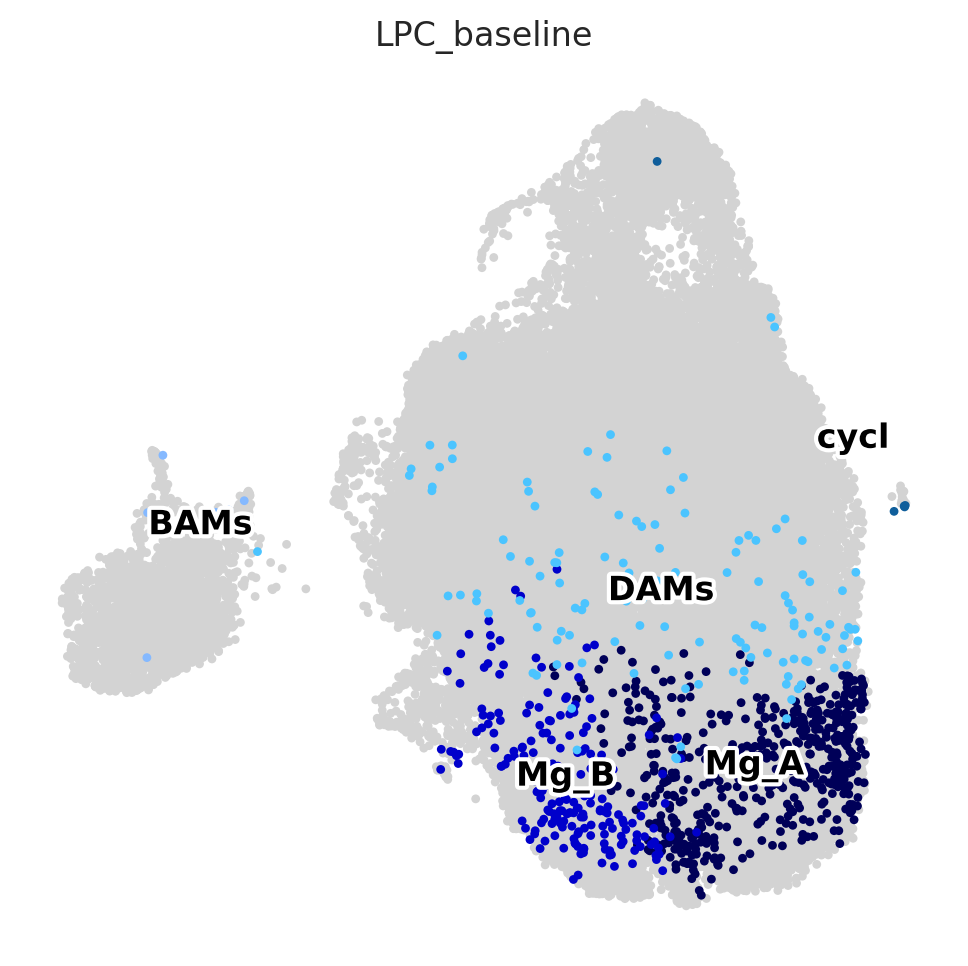

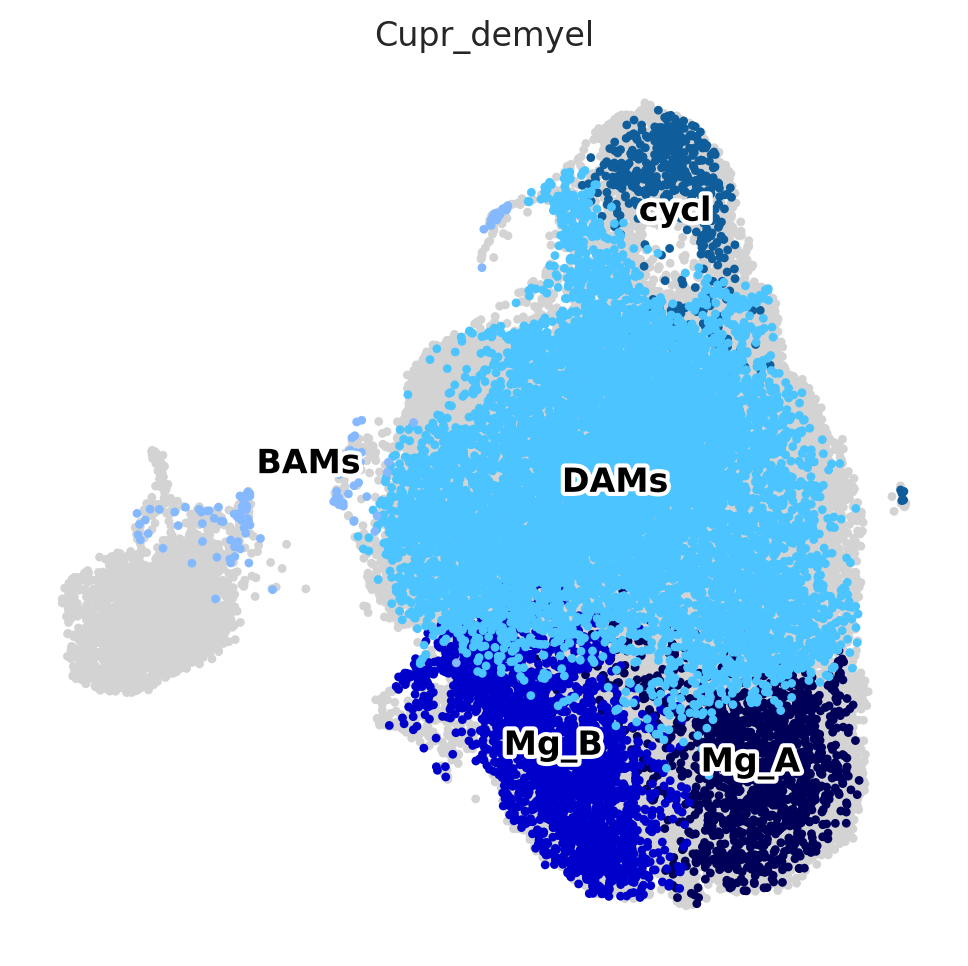

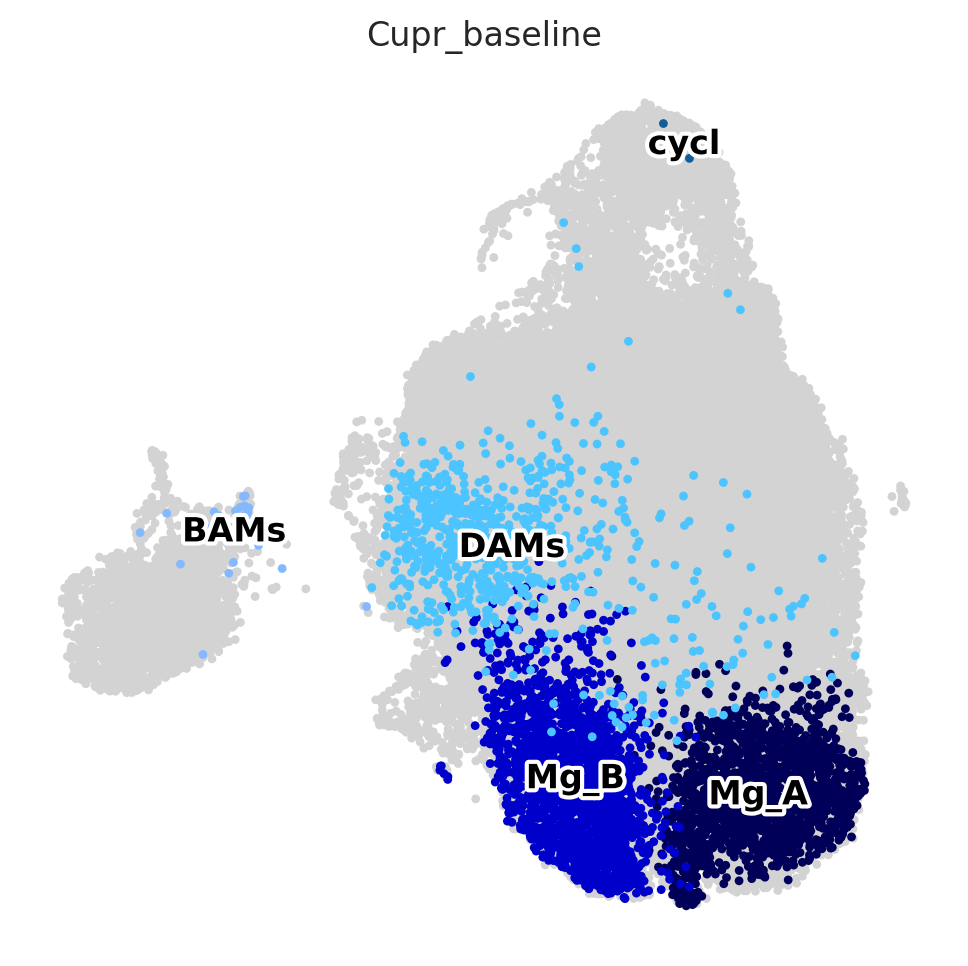

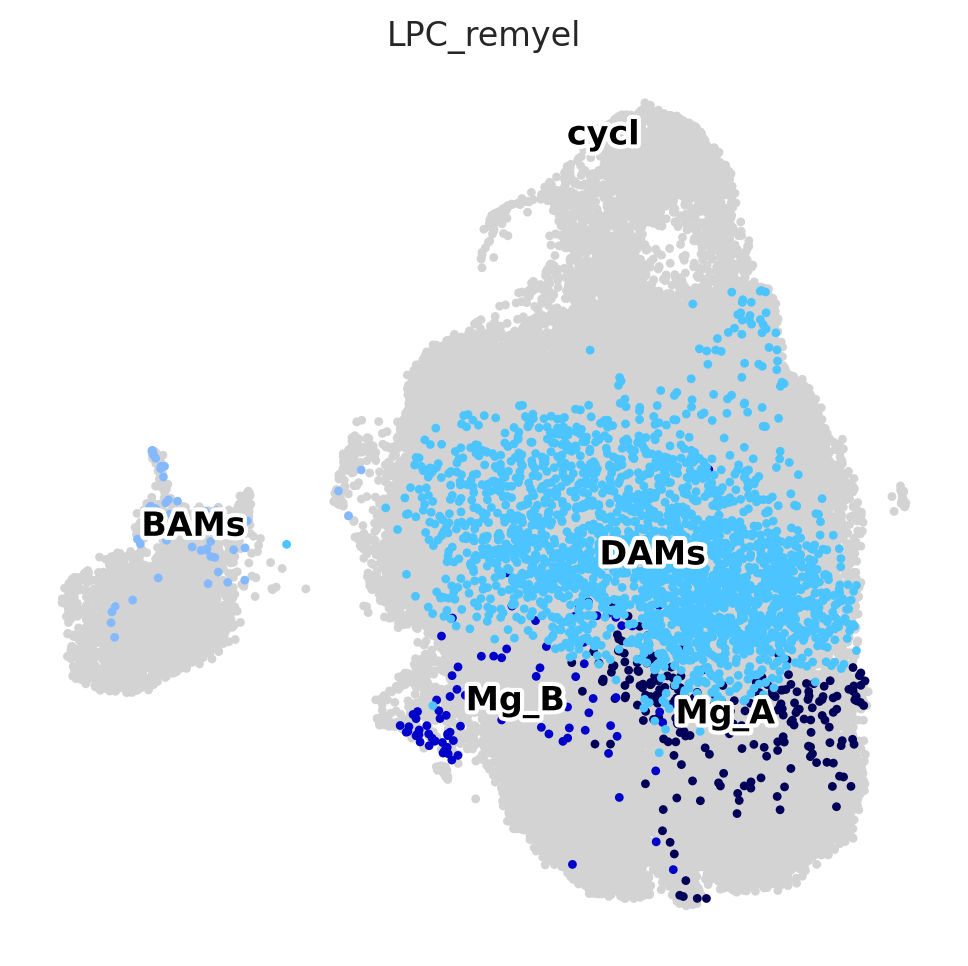

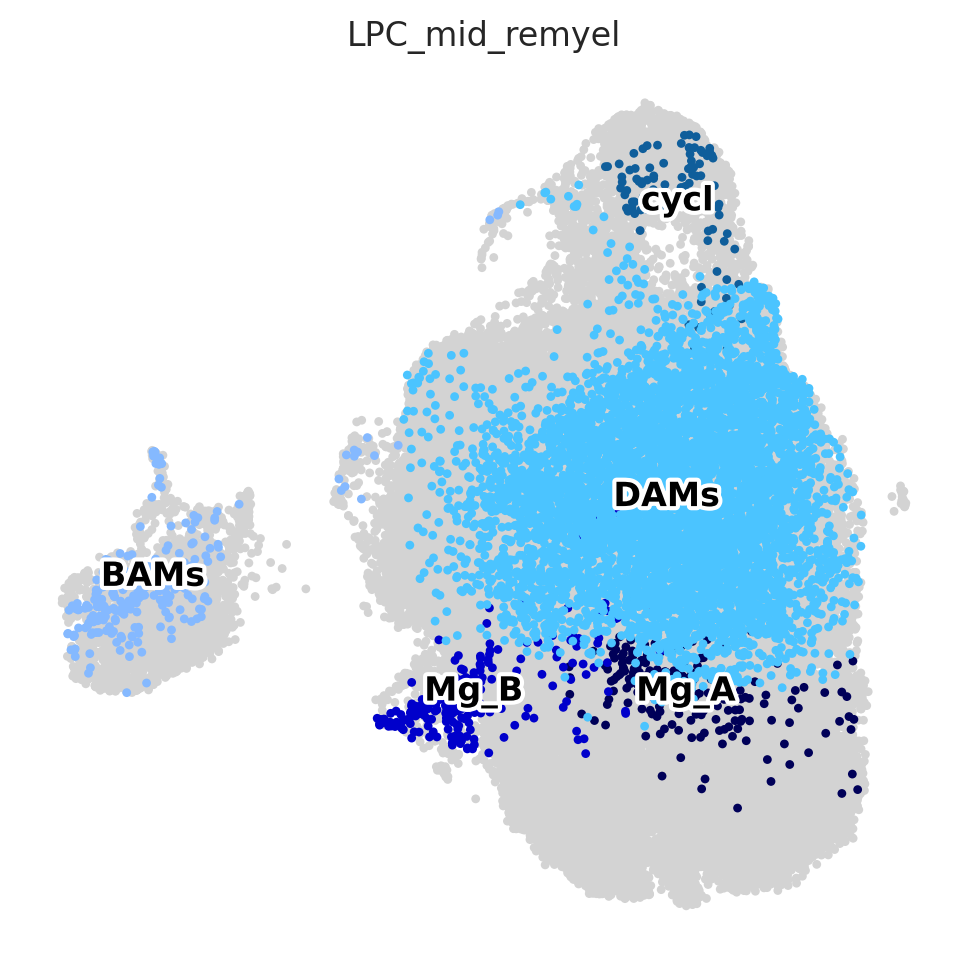

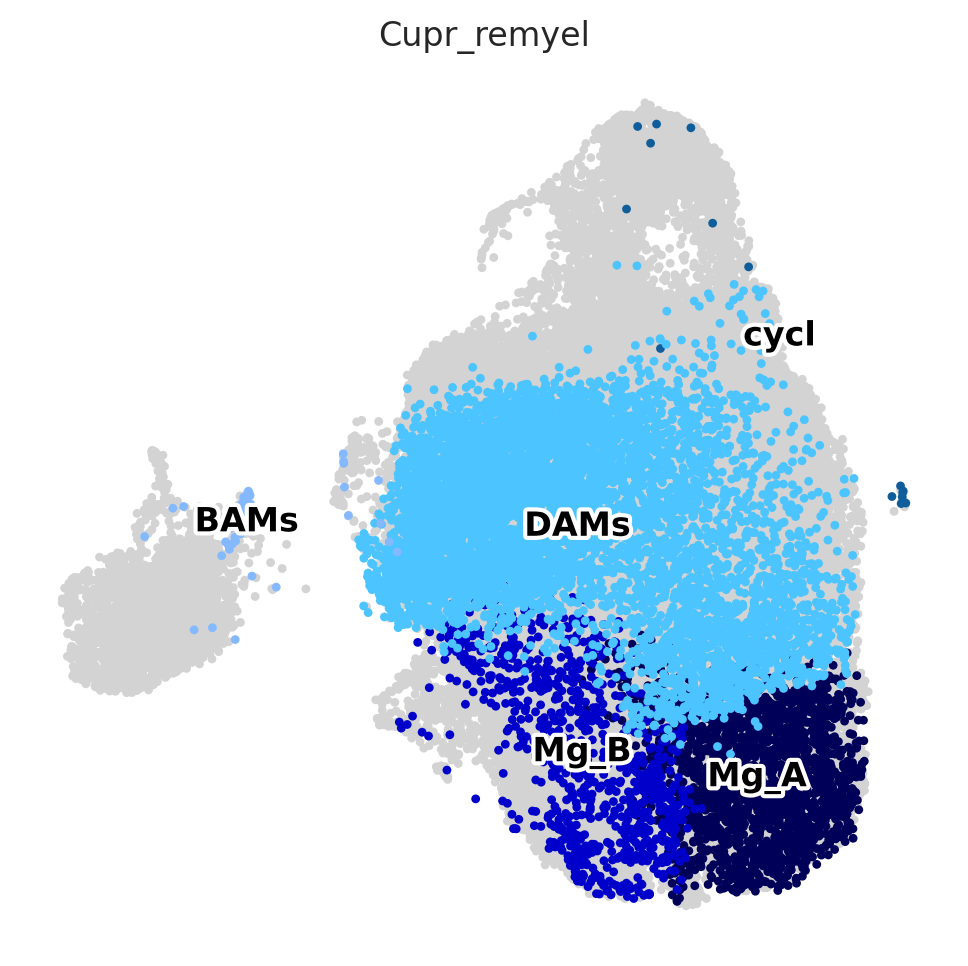

In [21]:
cluster_color = {     
    'cycl': '#0f5e9b',  
    'Mg_A': '#000058',    
    'Mg_B': '#0000cb', 
    'DAMs': '#4bc4ff', 
    'BAMs': '#85b9ff', 
}

# Set a grey color for cells not in the current lesion_status
grey_color = '#d3d3d3'

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from matplotlib import patheffects  # Import for text outline effects

# Iterate over unique lesion_statuses
for lesion_status in adata.obs['lesion_status'].unique():
    # Create a mask for cells in the specific lesion_status
    lesion_mask = adata.obs['lesion_status'] == lesion_status

    # Initialize color vector for cells not in the lesion_status
    colors = np.array([grey_color] * adata.shape[0])  # Initialize all to grey

    # Plot UMAP with grey dots first
    plt.figure(figsize=(5, 5))  # Ensure figure size matches settings
    umap_coords = adata.obsm['X_umap']
    grey_mask = ~lesion_mask
    plt.scatter(umap_coords[grey_mask, 0], umap_coords[grey_mask, 1], 
                color=grey_color, s=10, edgecolor='none')

    # Overlay cell type colors on top
    for cell_type, cell_color in cluster_color.items():
        # Assign the specific cluster color for cells of the current type in the lesion_status
        cell_type_mask = (adata.obs['cell_type'] == cell_type) & lesion_mask
        plt.scatter(umap_coords[cell_type_mask, 0], umap_coords[cell_type_mask, 1], 
                    color=cell_color, s=10, edgecolor='none')

        # Add labels to the UMAP at the centroid of the cluster
        if cell_type_mask.sum() > 0:  # Ensure there are points in the cluster
            centroid = umap_coords[cell_type_mask].mean(axis=0)  # Calculate centroid
            text = plt.text(
                centroid[0], centroid[1], cell_type, fontsize=12, color='black',
                ha='center', va='center', fontweight='bold'
            )

            # Add white outline to the text
            text.set_path_effects([
                patheffects.Stroke(linewidth=3, foreground='white'),  # White outline
                patheffects.Normal()  # Normal text on top
            ])

    # Customize plot appearance
    plt.title(f"{lesion_status}", fontsize=12)  # Ensure title is added with fontsize
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    # Remove grid and axes
    plt.grid(False)
    plt.gca().set_axis_off()

    # Save the plot with specified parameters
    plt.tight_layout()
    plt.savefig(f"{sc.settings.figdir}/{lesion_status}_combined_umap_SEP_DAMs_labels_mg.png", dpi=300, transparent=True)

    # Show the plot in the console
    plt.show()

    # Close the plot
    plt.close()

In [98]:
adata_LPC= adata[np.in1d(adata.obs['lesion_status'], 
                           ['LPC_baseline', 'LPC_demyel', 'LPC_remyel'])].copy()

print("Dimensions of adata_sub:", adata_LPC.shape)

Dimensions of adata_sub: (18999, 19308)


In [34]:
adata_Cupr= adata[np.in1d(adata.obs['lesion_status'], 
                           ['Cupr_baseline', 'Cupr_demyel', 'Cupr_remyel'])].copy()

print("Dimensions of adata_sub:", adata_Cupr.shape)

Dimensions of adata_sub: (27375, 19308)


In [35]:
#sc.pp.filter_cells(adata_Cupr, min_genes=200)
sc.pp.filter_genes(adata_LPC, min_cells=10)
print("Dimensions of adata_LPC:", adata_LPC.shape)

filtered out 1561 genes that are detected in less than 10 cells
Dimensions of adata_LPC: (18999, 17747)


In [36]:
#sc.pp.filter_cells(adata_Cupr, min_genes=200)
sc.pp.filter_genes(adata_Cupr, min_cells=10)
print("Dimensions of adata_Cupr:", adata_Cupr.shape)

filtered out 2915 genes that are detected in less than 10 cells
Dimensions of adata_Cupr: (27375, 16393)


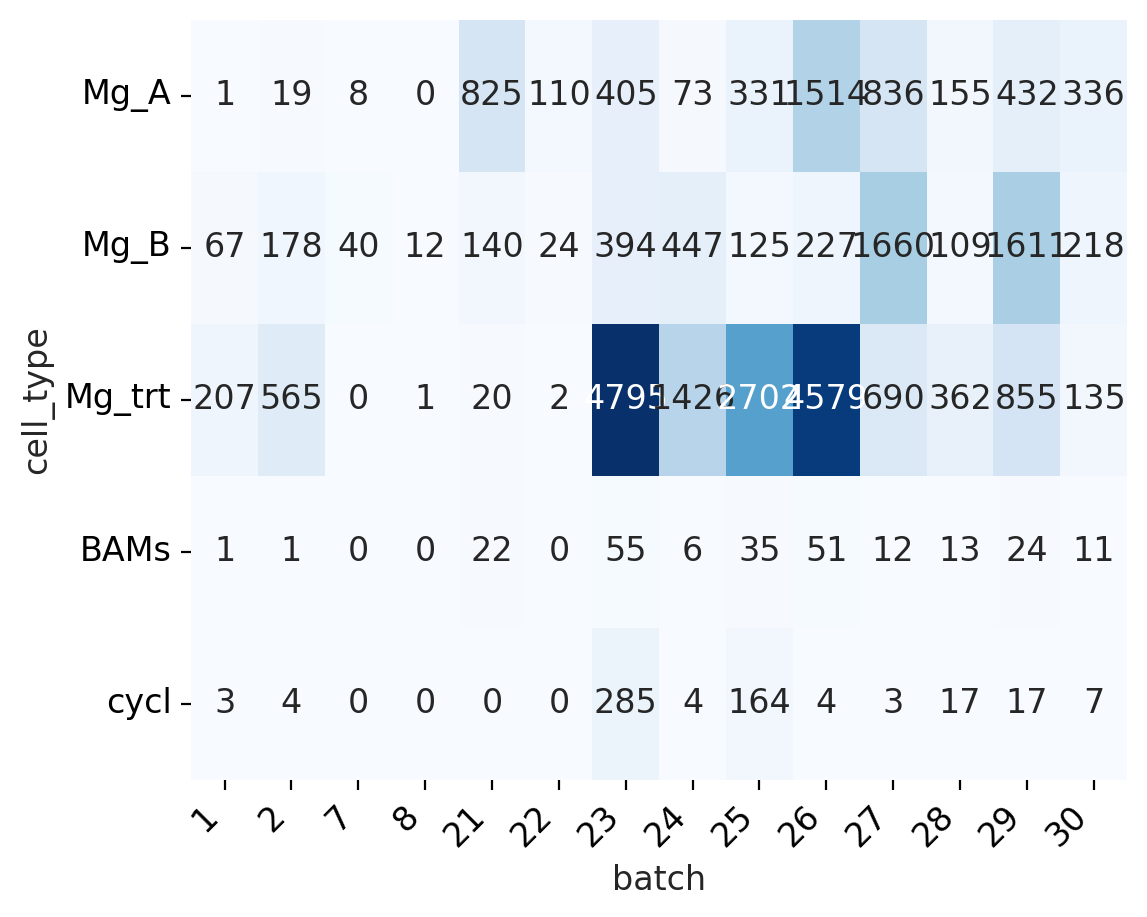

In [102]:
# Create the crosstab again
crosstab_df = pd.crosstab(adata_Cupr.obs.cell_type, adata_Cupr.obs.batch)

# Plot the heatmap
plt.figure(figsize=(6, 5))
ax = sb.heatmap(crosstab_df, cmap='Blues', annot=True, fmt="d", cbar=False, annot_kws={"size": 12})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.grid(False)

# Show the heatmap
plt.show()

# Set up obs columns

In [37]:
# Unique values in the 'condition' column
unique_conditions = adata_LPC.obs['individual_lesion_condition'].unique()
for condition in unique_conditions:
    print(condition)

LPC_7d
LPC_Saline
LPC_5d
LPC_28d
LPC_ctrl


In [38]:
adata_LPC.obs['sample_rep'] = adata_LPC.obs['individual_lesion_condition'].astype(str) + '_' + adata_LPC.obs['replicate'].astype(str)

In [39]:
unique_conditions = adata_LPC.obs['sample_rep'].unique()
for condition in unique_conditions:
    print(condition)

LPC_7d_2
LPC_Saline_2
LPC_Saline_1
LPC_7d_1
LPC_5d_1
LPC_5d_3
LPC_28d_3
LPC_ctrl_3
LPC_28d_1
LPC_5d_2
LPC_28d_2
LPC_5d_4
LPC_ctrl_2
LPC_ctrl_1


In [40]:
sample_map = {
    'LPC_7d_2': 'stim_1',
    'LPC_Saline_2': 'ctrl_1',
    'LPC_Saline_1': 'ctrl_2',
    'LPC_7d_1': 'stim_2',
    'LPC_5d_1': 'stim_3',
    'LPC_5d_3': 'stim_4',
    'LPC_28d_3': 'stim_5',
    'LPC_ctrl_3': 'ctrl_3',
    'LPC_28d_1': 'stim_6',
    'LPC_5d_2': 'stim_7',
    'LPC_28d_2': 'stim_8',
    'LPC_14d_1': 'stim_9',
    'LPC_14d_2': 'stim_10',
    'LPC_5d_4': 'stim_11',
    'LPC_ctrl_2': 'ctrl_4',
    'LPC_ctrl_1': 'ctrl_5',
}

# Update the 'treatment_meta' column based on the mapping
adata_LPC.obs['sample'] = adata_LPC.obs['sample_rep'].map(sample_map)

In [41]:
# Unique values in the 'condition' column
unique_conditions = adata_LPC.obs['sample'].unique()
for condition in unique_conditions:
    print(condition)

stim_1
ctrl_1
ctrl_2
stim_2
stim_3
stim_4
stim_5
ctrl_3
stim_6
stim_7
stim_8
stim_11
ctrl_4
ctrl_5


In [42]:
sample_map = {
    'stim_1': '1',
    'ctrl_1': '1',
    'ctrl_2': '2',
    'stim_2': '2',
    'stim_3': '3',
    'stim_4': '4',
    'stim_5': '5',
    'ctrl_3': '3',
    'stim_6': '6',
    'stim_7': '7',
    'stim_8': '8',
    'stim_9': '9',
    'stim_10': '10',
    'stim_11': '11',
    'ctrl_4': '4',
    'ctrl_5': '5',
}

# Update the 'treatment_meta' column based on the mapping
adata_LPC.obs['replicate_new'] = adata_LPC.obs['sample'].map(sample_map)

In [43]:
sample_map = {
    'stim_1': 'stim',
    'ctrl_1': 'ctrl',
    'ctrl_2': 'ctrl',
    'stim_2': 'stim',
    'stim_3': 'stim',
    'stim_4': 'stim',
    'stim_5': 'stim',
    'ctrl_3': 'ctrl',
    'stim_6': 'stim',
    'stim_7': 'stim',
    'stim_8': 'stim',
    'stim_9': 'stim',
    'stim_10': 'stim',
    'stim_11': 'stim',
    'ctrl_4': 'ctrl',
    'ctrl_5': 'ctrl',
}

# Update the 'treatment_meta' column based on the mapping
adata_LPC.obs['label'] = adata_LPC.obs['sample'].map(sample_map)

In [44]:
# Convert 'replicate_new' to a categorical type
adata_LPC.obs['replicate_cat'] = adata_LPC.obs['replicate_new'].astype('category')

In [45]:
print(len(adata_LPC[adata_LPC.obs["label"] == "ctrl"].obs["replicate_cat"].cat.categories))
print(len(adata_LPC[adata_LPC.obs["label"] == "stim"].obs["replicate_cat"].cat.categories))

5
9


In [46]:
# Unique values in the 'condition' column
unique_conditions = adata_Cupr.obs['individual_lesion_condition'].unique()
for condition in unique_conditions:
    print(condition)

Cupr_5w
Cupr_ctrl_Adams
Cupr_4+3w
Cupr_4w
Cupr_ctrl_Shen


In [47]:
adata_Cupr.obs['sample_rep'] = adata_Cupr.obs['individual_lesion_condition'].astype(str) + '_' + adata_Cupr.obs['replicate'].astype(str)
unique_conditions = adata_Cupr.obs['sample_rep'].unique()
for condition in unique_conditions:
    print(condition)

Cupr_5w_1
Cupr_5w_2
Cupr_ctrl_Adams_1
Cupr_ctrl_Adams_2
Cupr_4+3w_1
Cupr_4w_3
Cupr_4w_2
Cupr_ctrl_Shen_2
Cupr_ctrl_Shen_1
Cupr_4+3w_3
Cupr_4w_4
Cupr_4+3w_2
Cupr_4w_1
Cupr_ctrl_Shen_3


In [48]:
sample_map = {
    'Cupr_5w_1': 'stim_1',
    'Cupr_5w_2': 'stim_2',
    'Cupr_ctrl_Adams_1': 'ctrl_1',
    'Cupr_ctrl_Adams_2': 'ctrl_2',
    'Cupr_4+3w_1': 'stim_3',
    'Cupr_4w_3': 'stim_4',
    'Cupr_4w_2': 'stim_5',
    'Cupr_ctrl_Shen_2': 'ctrl_3',
    'Cupr_ctrl_Shen_1': 'ctrl_4',
    'Cupr_4+3w_3': 'stim_6',
    'Cupr_4w_4': 'stim_7',
    'Cupr_4+3w_2': 'stim_8',
    'Cupr_4w_1': 'stim_9',
    'Cupr_ctrl_Shen_3': 'ctrl_5',
}

# Update the 'treatment_meta' column based on the mapping
adata_Cupr.obs['sample'] = adata_Cupr.obs['sample_rep'].map(sample_map)

In [49]:
# Unique values in the 'condition' column
unique_conditions = adata_Cupr.obs['sample'].unique()
for condition in unique_conditions:
    print(condition)

stim_1
stim_2
ctrl_1
ctrl_2
stim_3
stim_4
stim_5
ctrl_3
ctrl_4
stim_6
stim_7
stim_8
stim_9
ctrl_5


In [50]:
sample_map = {
    'stim_1': '1',
    'ctrl_1': '1',
    'ctrl_2': '2',
    'stim_2': '2',
    'stim_3': '3',
    'stim_4': '4',
    'stim_5': '5',
    'ctrl_3': '3',
    'stim_6': '6',
    'stim_7': '7',
    'stim_8': '8',
    'stim_9': '9',
    'ctrl_4': '4',
    'ctrl_5': '5',
}

# Update the 'treatment_meta' column based on the mapping
adata_Cupr.obs['replicate_new'] = adata_Cupr.obs['sample'].map(sample_map)

In [51]:
sample_map = {
    'stim_1': 'stim',
    'ctrl_1': 'ctrl',
    'ctrl_2': 'ctrl',
    'stim_2': 'stim',
    'stim_3': 'stim',
    'stim_4': 'stim',
    'stim_5': 'stim',
    'ctrl_3': 'ctrl',
    'stim_6': 'stim',
    'stim_7': 'stim',
    'stim_8': 'stim',
    'stim_9': 'stim',
    'ctrl_4': 'ctrl',
    'ctrl_5': 'ctrl',
}

# Update the 'treatment_meta' column based on the mapping
adata_Cupr.obs['label'] = adata_Cupr.obs['sample'].map(sample_map)

# Convert 'replicate_new' to a categorical type
adata_Cupr.obs['replicate_cat'] = adata_Cupr.obs['replicate_new'].astype('category')

In [52]:
print(len(adata_Cupr[adata_Cupr.obs["label"] == "ctrl"].obs["replicate_cat"].cat.categories))
print(len(adata_Cupr[adata_Cupr.obs["label"] == "stim"].obs["replicate_cat"].cat.categories))

5
9


# Pseudobulk LPC

In [53]:
NUM_OF_CELL_PER_DONOR = 15

def aggregate_and_filter(
    adata, #input anndata
    cell_identity, #subset for processing by cell type
    donor_key="sample", #'6_stim' sets the donor key as reps for each condition
    condition_key="label", #ctrl or stim
    cell_identity_key="cell_type", #cell type identifier
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [54]:
obs_to_keep = ["publication", "label", "cell_type", "replicate_cat", "sample", "sample_rep"]

In [55]:
adata_LPC.X = adata_LPC.layers["counts"].copy()

In [56]:
adata_LPC.obs["cell_type"] = adata_LPC.obs["cell_type"].astype("category")

In [57]:
# process first cell type separately...
cell_type = adata_LPC.obs["cell_type"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(adata_LPC.obs["cell_type"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(adata_LPC, cell_type, obs_to_keep=obs_to_keep)
for i, cell_type in enumerate(adata_LPC.obs["cell_type"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata_LPC.obs["cell_type"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata_LPC, cell_type, obs_to_keep=obs_to_keep)
    adata_pb = adata_pb.concatenate(adata_cell_type)

Processing Mg_A (1 out of 5)...
Dropping the following samples:
['ctrl_3', 'stim_4', 'stim_7']
	Processing donor 14 out of 14...

Processing Mg_B (2 out of 5)...
Dropping the following samples:
['ctrl_3', 'ctrl_4', 'stim_4']
	Processing donor 14 out of 14...

Processing Mg_trt (3 out of 5)...
Dropping the following samples:
['ctrl_3', 'ctrl_4']
	Processing donor 14 out of 14...

Processing BAMs (4 out of 5)...
Dropping the following samples:
['ctrl_1', 'ctrl_2', 'ctrl_4', 'ctrl_5']
	Processing donor 13 out of 13...

Processing cycl (5 out of 5)...
Dropping the following samples:
['ctrl_1', 'ctrl_2', 'stim_5']
	Processing donor 9 out of 9...



In [58]:
adata_pb.layers['counts'] = adata_pb.X.copy()
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=48
    finished (0:00:00)


In [59]:
# Ensure counts are integers (if not already)
adata_pb.layers["counts"] = adata_pb.layers["counts"].astype(int)

# Calculate library size
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)

# Calculate log library size
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"].astype(float))

adata_pb.obs["replicate"] = adata_pb.obs["replicate_cat"].astype("category")
adata_pb.obs["label"] = adata_pb.obs["label"].astype("category")
adata_pb.obs["sample"] = adata_pb.obs["sample"].astype("category")
adata_pb.obs["cell_type"] = adata_pb.obs["cell_type"].astype("category")
adata_pb.obs["publication"] = adata_pb.obs["publication"].astype("category")
adata_pb.obs["sample_rep"] = adata_pb.obs["sample_rep"].astype("category")

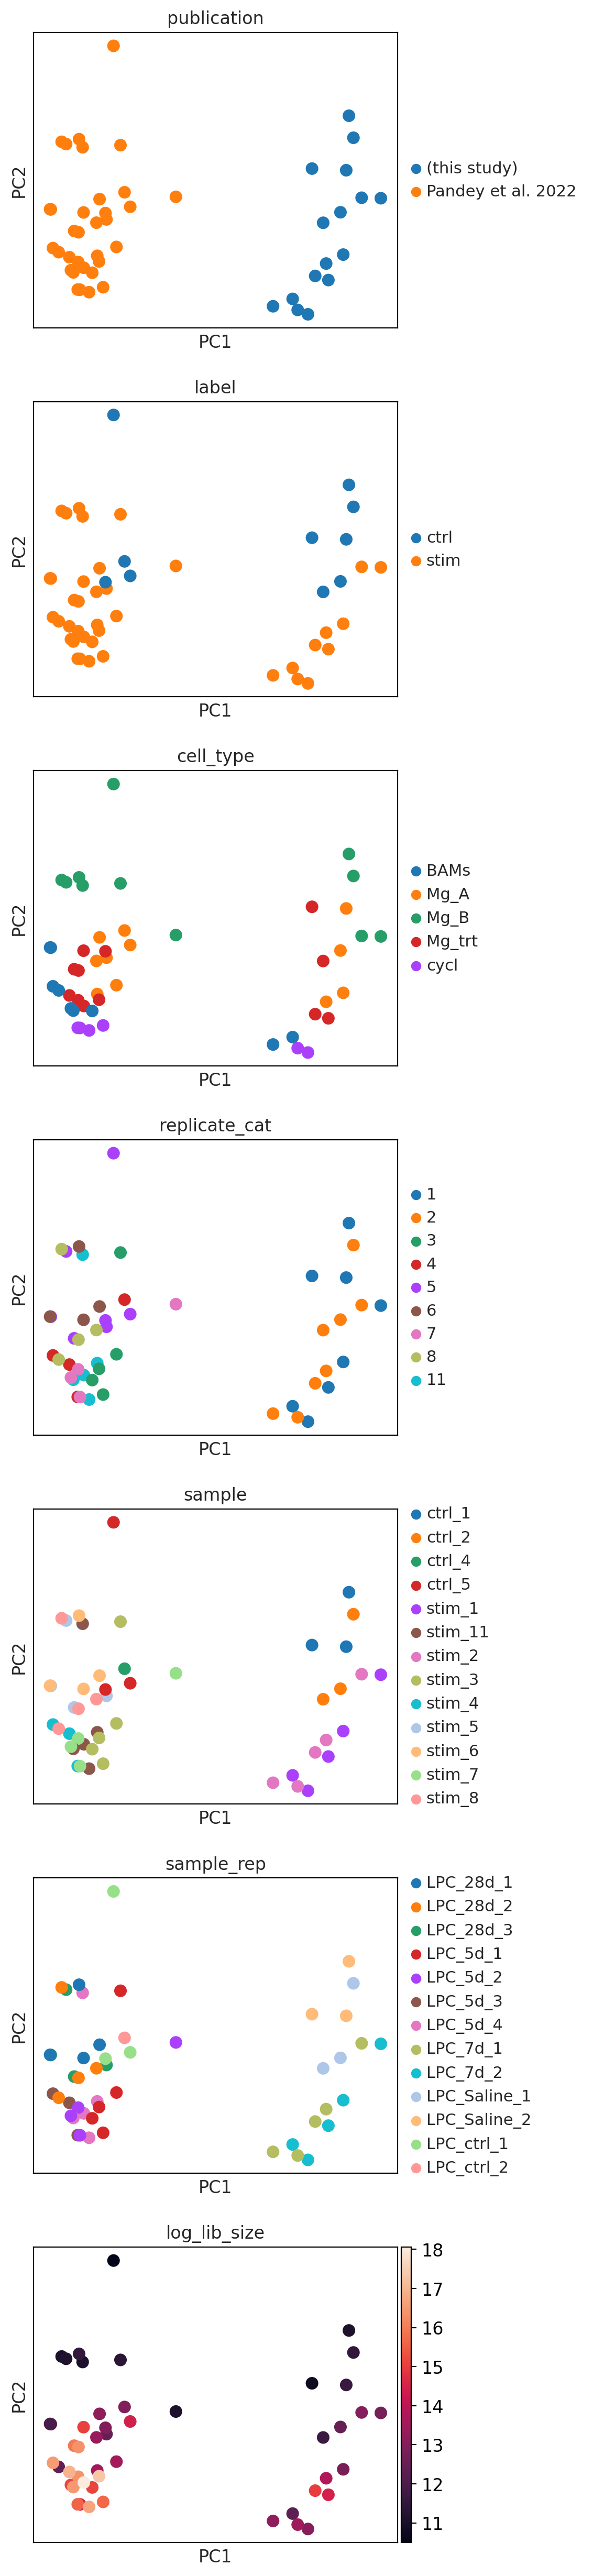

In [60]:
sc.pl.pca(adata_pb, color=["publication", "label", "cell_type", "replicate_cat", 
                           "sample", "sample_rep", "log_lib_size"], ncols=1, size=300)

In [61]:
adata_pb.X = adata_pb.layers['counts'].copy()

In [62]:
adata_pb.write_h5ad('./pb_adata_LPC_Mg.h5ad')

# Now on cupr

In [63]:
NUM_OF_CELL_PER_DONOR = 15

def aggregate_and_filter(
    adata, #input anndata
    cell_identity, #subset for processing by cell type
    donor_key="sample", #'6_stim' sets the donor key as reps for each condition
    condition_key="label", #ctrl or stim
    cell_identity_key="cell_type", #cell type identifier
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [64]:
obs_to_keep = ["publication", "label", "cell_type", "replicate_cat", "sample", "sample_rep"]

In [65]:
adata_Cupr.X = adata_Cupr.layers["counts"].copy()

In [66]:
adata_Cupr.obs["cell_type"] = adata_Cupr.obs["cell_type"].astype("category")

In [67]:
# process first cell type separately...
cell_type = adata_Cupr.obs["cell_type"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(adata_Cupr.obs["cell_type"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(adata_Cupr, cell_type, obs_to_keep=obs_to_keep)
for i, cell_type in enumerate(adata_Cupr.obs["cell_type"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata_Cupr.obs["cell_type"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata_Cupr, cell_type, obs_to_keep=obs_to_keep)
    adata_pb = adata_pb.concatenate(adata_cell_type)

Processing Mg_A (1 out of 5)...
Dropping the following samples:
['ctrl_1', 'stim_1']
	Processing donor 13 out of 13...

Processing Mg_B (2 out of 5)...
Dropping the following samples:
['ctrl_2']
	Processing donor 14 out of 14...

Processing Mg_trt (3 out of 5)...
Dropping the following samples:
['ctrl_2', 'ctrl_3']
	Processing donor 13 out of 13...

Processing BAMs (4 out of 5)...
Dropping the following samples:
['ctrl_5', 'stim_1', 'stim_2', 'stim_3', 'stim_4', 'stim_6']
	Processing donor 11 out of 11...

Processing cycl (5 out of 5)...
Dropping the following samples:
['ctrl_5', 'stim_1', 'stim_2', 'stim_3', 'stim_6', 'stim_8']
	Processing donor 10 out of 10...



In [68]:
adata_pb.layers['counts'] = adata_pb.X.copy()
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=43
    finished (0:00:00)


In [69]:
# Ensure counts are integers (if not already)
adata_pb.layers["counts"] = adata_pb.layers["counts"].astype(int)

# Calculate library size
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)

# Calculate log library size
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"].astype(float))

adata_pb.obs["replicate"] = adata_pb.obs["replicate_cat"].astype("category")
adata_pb.obs["label"] = adata_pb.obs["label"].astype("category")
adata_pb.obs["sample"] = adata_pb.obs["sample"].astype("category")
adata_pb.obs["cell_type"] = adata_pb.obs["cell_type"].astype("category")
adata_pb.obs["publication"] = adata_pb.obs["publication"].astype("category")
adata_pb.obs["sample_rep"] = adata_pb.obs["sample_rep"].astype("category")

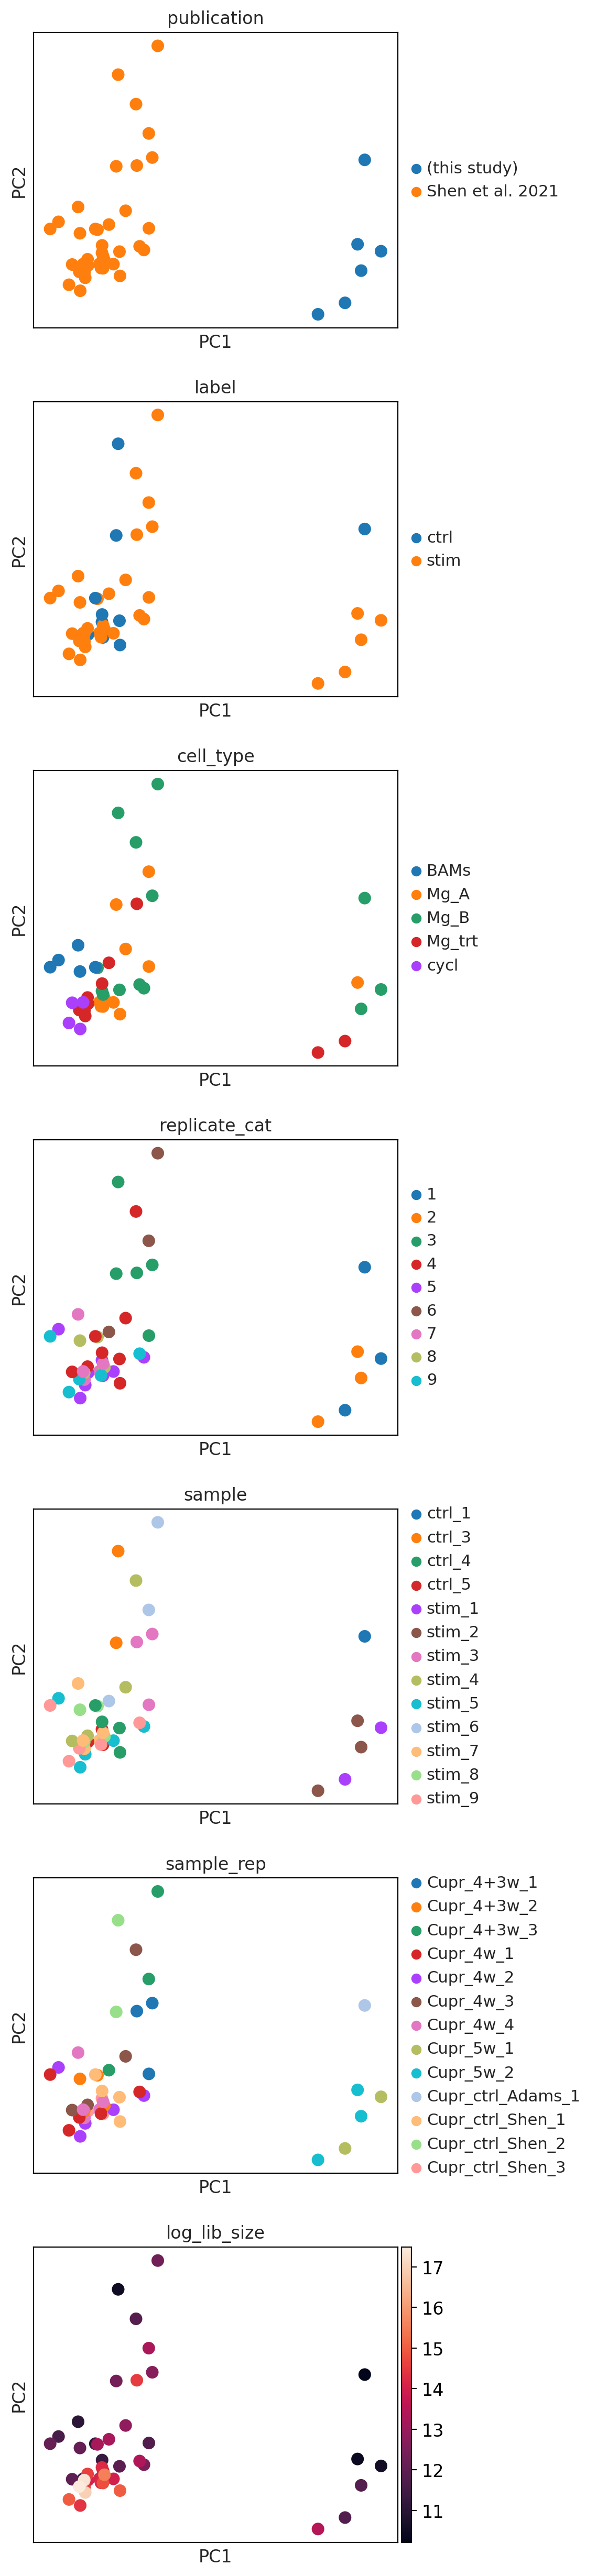

In [70]:
sc.pl.pca(adata_pb, color=["publication", "label", "cell_type", "replicate_cat", 
                           "sample", "sample_rep", "log_lib_size"], ncols=1, size=300)

In [71]:
adata_pb.X = adata_pb.layers['counts'].copy()

In [72]:
adata_pb.write_h5ad('./pb_adata_Cupr_Mg.h5ad')